In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from rdkit import Chem
from rdkit.Chem import GetPeriodicTable, rdchem, rdEHTTools, rdmolops, rdDetermineBonds, AllChem, Draw

from ase.io import read, write


import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GraphNorm, BatchNorm, LayerNorm
from torch.nn import Parameter, Identity, ModuleList, Linear, ReLU, Dropout, MSELoss
from torch_geometric.utils import add_remaining_self_loops, remove_self_loops, softmax, remove_self_loops, add_self_loops

from torch_geometric.nn import SchNet

import torch.nn as nn
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.optim as optim

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, make_scorer, mean_squared_error, r2_score

import copy
from collections import Counter

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 1
Device 0: NVIDIA GeForce RTX 4060 Ti


In [3]:
# All data containing 2267 complexes and redox potentials
full_data_df = pd.read_csv('../Data/tmqm_redox_data_full_data.csv')

# Mol and smiles of complexes generated directly from tmQM dataset
tmqm_final_df = pd.read_pickle('../Data/tmc_frm_xyz2mol_tmqm_all_df.pkl')
tmqm_final_df = tmqm_final_df.drop_duplicates(subset='csd_code', keep='first')

# Mol and smiles of complexes generated after DFT-redox calculations
final_df = pd.read_pickle('../Data/tmc_frm_xyz2mol_desolvated_all_df.pkl')
final_df = final_df.drop_duplicates(subset='csd_code', keep='first')

In [4]:
# Filter out rows in final_df
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    if csd not in tmqm_final_df['csd_code'].values:
        rows_to_delete.append(idx)
        continue
    mol = row['mol']

    atoms = mol.GetAtoms()
    max_valence = 0
    Fe_charge = None
    for _, atom in enumerate(atoms):
        max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
        if atom.GetSymbol() == 'Fe':
            Fe_charge = atom.GetFormalCharge()

    if max_valence > 7:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)
    if Fe_charge > 3 or Fe_charge < 0:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)

# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
params = Chem.MolStandardize.rdMolStandardize.MetalDisconnectorOptions()
params.splitAromaticC = True
params.splitGrignards = True
params.adjustCharges = False
MetalNon_Hg = "[#3,#11,#12,#19,#13,#21,#22,#23,#24,#25,#26,#27,#28,#29,#30,#39,#40,#41,#42,#43,#44,#45,#46,#47,#48,#57,#72,#73,#74,#75,#76,#77,#78,#79,#80]~[B,#6,#14,#15,#33,#51,#16,#34,#52,Cl,Br,I,#85]"
mdis = rdMolStandardize.MetalDisconnector(params)
mdis.SetMetalNon(Chem.MolFromSmarts(MetalNon_Hg))

count = 0
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    if csd not in tmqm_final_df['csd_code'].values:
        rows_to_delete.append(idx)
        continue
    mol = row['mol']
    tmqm_mol = tmqm_final_df[tmqm_final_df['csd_code'] == csd]['mol'].values[0]

    # check number of ligands
    frags = mdis.Disconnect(mol)
    tmqm_frags = mdis.Disconnect(tmqm_mol)

    frag_mols = rdmolops.GetMolFrags(frags, asMols=True)
    tmqm_frag_mols = rdmolops.GetMolFrags(tmqm_frags, asMols=True)
    if len(frag_mols) != len(tmqm_frag_mols):
        if idx not in rows_to_delete:
            print(f"Skipping {csd} due to different number of ligands: {len(frag_mols)} vs {len(tmqm_frag_mols)}")
            rows_to_delete.append(idx)
            count += 1
    
print(f"Total rows to delete: {count}")
# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [6]:
print(f"Total rows to delete: {count}")

final_df

Total rows to delete: 29


,csd_code,mol,smiles,desolv_atoms,tmqm_atoms,y
0,ABISOV,<rdkit.Chem.rdchem.Mol object at 0x000002138D2...,S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...,"(Atom('Fe', [np.float64(9.314544), np.float64(...","(Atom('Fe', [np.float64(9.45301159474186), np....",0.198685
1,ABITEM,<rdkit.Chem.rdchem.Mol object at 0x000002138D2...,S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...,"(Atom('Fe', [np.float64(7.286369), np.float64(...","(Atom('Fe', [np.float64(7.50803351987049), np....",0.354905
2,ABIVAK,<rdkit.Chem.rdchem.Mol object at 0x000002138D2...,S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...,"(Atom('Fe', [np.float64(-13.328241), np.float6...","(Atom('Fe', [np.float64(-13.19623389441261), n...",0.207419
3,ACAZFE,<rdkit.Chem.rdchem.Mol object at 0x000002138D2...,CC(=O)c1c[nH][cH-]2->[Fe+2]34(<-[C-]#[O+])(<-[...,"(Atom('C', [np.float64(1.89194), np.float64(2....","(Atom('C', [np.float64(2.39653748899036), np.f...",0.945131
4,ACUZII,<rdkit.Chem.rdchem.Mol object at 0x000002138D2...,CC1(C)O[C-](=O)->[Fe+2](<-[C-]#[O+])(<-[C-]#[O...,"(Atom('Fe', [np.float64(13.442061), np.float64...","(Atom('Fe', [np.float64(13.76449478713283), np...",2.261145
...,...,...,...,...,...,...
1445,ZOMKAR,<rdkit.Chem.rdchem.Mol object at 0x000002138D3...,CN(C)C(N(C)C)=[N]1CCC[N](=C(N(C)C)N(C)C)->[Fe+...,"(Atom('Fe', [np.float64(9.511264), np.float64(...","(Atom('Fe', [np.float64(9.85343477883966), np....",-0.082576
1446,ZORGUL,<rdkit.Chem.rdchem.Mol object at 0x000002138D4...,O=[N+]([O-])c1cn2[BH-]3n4ccc[n]4->[Fe+2]45(<-[...,"(Atom('Fe', [np.float64(-0.241791), np.float64...","(Atom('Fe', [np.float64(-0.23539035079073), np...",0.170708
1447,ZOVKEC,<rdkit.Chem.rdchem.Mol object at 0x000002138D4...,Cc1[c]2(C)->[Fe+2]34(<-[C-]#[O+])(<-[c-]5n(C)c...,"(Atom('Fe', [np.float64(3.368125), np.float64(...","(Atom('Fe', [np.float64(3.62887408906367), np....",1.178587
1448,ZOWLII,<rdkit.Chem.rdchem.Mol object at 0x000002138D3...,CN1c2ccccc2N2c3ccccc3-c3ccccc3N3c4ccccc4N(C)[C...,"(Atom('Fe', [np.float64(7.495714), np.float64(...","(Atom('Fe', [np.float64(7.7543618396066), np.f...",0.070925


# Functions to generate graphs (Although Dimenet does not use or need graph data)

### These functions are still for data splits later. This is done to keep the overall code structure the same across all models in this repo

In [7]:
# Helper functions

from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator


def get_num_Hs(atom):
    """
    Returns the number of hydrogen atoms bonded to the given atom.
    """
    num_Hs = 0
    for neighbor in atom.GetNeighbors():
        if neighbor.GetAtomicNum() == 1:  # Atomic number 1 corresponds to hydrogen
            num_Hs += 1
    return num_Hs

    
def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

# Creating dataset

# Define constants for hybridizations and stereoisomers
hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED
        ]

stereos = [rdchem.BondStereo.STEREONONE, rdchem.BondStereo.STEREOANY,
           rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE]

# Define periodic table for atomic properties
periodic_table = Chem.GetPeriodicTable()


def GenGraphs(df, mfp_mask=None, mfp_radius = 3, mfp_bits = 2048):
    data_list = []
    
    # Mols
    mol_list = df['mol'].tolist()
    
    # Graph features
    #homoE_list = df['HOMO_Energy'].tolist()
    #lumoE_list = df['LUMO_Energy'].tolist()
    #polarize_list = df['Polarizability'].tolist()
    #electronic_E_list = df['Electronic_E'].tolist()
    #dispersion_E_list = df['Dispersion_E'].tolist()

    smiles_list = df['smiles'].tolist()
    
    # target
    y_list = df['y'].tolist()

    
    for idx, mol in enumerate(mol_list):
        
        y = y_list[idx]
        y = torch.tensor(y, dtype=torch.float).view(-1, 1)

        #homoE = torch.tensor([homoE_list[idx]], dtype=torch.float)
        #lumoE = torch.tensor([lumoE_list[idx]], dtype=torch.float)
        #polarize = torch.tensor([polarize_list[idx]], dtype=torch.float)
        #electronic_E = torch.tensor([electronic_E_list[idx]], dtype=torch.float)
        #dispersion_E = torch.tensor([dispersion_E_list[idx]], dtype=torch.float)
    

        smiles = smiles_list[idx]
        
        # Compute Morgan fingerprint
        morgan_fp = compute_morgan_fingerprint(mol, radius=mfp_radius, fpSize=mfp_bits)
        n_features = morgan_fp.shape[0]
        if mfp_mask is None:
            mfp_mask = np.ones(n_features, dtype=bool)
        morgan_fp = morgan_fp[mfp_mask]
        morgan_fp_tensor = torch.tensor(list(morgan_fp), dtype=torch.float)
        #print(sum(morgan_fp_tensor), len(morgan_fp_tensor))

        #mol = Chem.MolFromSmiles(smiles)
        #if mol is None:
        #    continue  # Skip invalid SMILES

        

        # Add hydrogens
        
        #mol = Chem.AddHs(mol)
        
        atoms = mol.GetAtoms()
        max_valence = 0
        for _, atom in enumerate(atoms):
            max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
        
        if max_valence > 7:
            continue
        if Fe_charge > 3 or Fe_charge < 0:
            continue

        conformer = mol.GetConformer() # Get the default conformer
        pos = [conformer.GetAtomPosition(atom.GetIdx()) for atom in mol.GetAtoms()]
        pos = torch.tensor(pos, dtype=torch.float)
        
        xs = []
        Fe_neigh_symbols = [0] * 92
        Fe_neigh_charge = 0
        for atom in atoms:
            atomic_num_scaled = float((atom.GetAtomicNum() - 1) / 91)  # H: 1, U: 92
            symbol = [0] * 92 #len(periodic_table.GetMaxAtomicNumber())
            try:
                symbol[periodic_table.GetAtomicNumber(atom.GetSymbol()) - 1] = 1.
            except IndexError:
                continue
            
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
                # Get neighbors of the Fe atom
                neighbors = atom.GetNeighbors()
                for neighbor in neighbors:
                    # Get the symbol of the neighbor atom
                    neigh_symbol = neighbor.GetSymbol()
                    # Append the symbol to the list
                    try:
                        Fe_neigh_symbols[periodic_table.GetAtomicNumber(neigh_symbol) - 1] = 1.
                    except IndexError:
                        continue
                    Fe_neigh_charge += neighbor.GetFormalCharge()
                
                Fe_neigh_charge = torch.tensor([Fe_neigh_charge], dtype=torch.float)
                Fe_neigh_symbols = torch.tensor(Fe_neigh_symbols, dtype=torch.float)
            
            #print(atom.GetSymbol(), atom.GetFormalCharge(), atom.GetDegree(), atom.GetHybridization(), atom.GetTotalNumHs())
            valance = [0.] * 8
            valance[atom.GetDegree()] = 1.

            formal_charge = atom.GetFormalCharge()   # [-3, -2, -1, 0, 1, 2, 3]
            radical_electrons = atom.GetNumRadicalElectrons()
            
            hybridization = [0.] * len(hybridizations)
            if atom.GetHybridization() in hybridizations:
                hybridization[hybridizations.index(atom.GetHybridization())] = 1.
                
            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            try:
                hydrogens[get_num_Hs(atom)] = 1.
            except IndexError: # Handle cases with > 4 explicit Hs if possible
                 print(f"Warning: Atom {atom.GetIdx()} in mol {idx} has unexpected num Hs {get_num_Hs(atom)}.")
            #print(atom.GetSymbol(), hydrogens)
            
            '''chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            if atom.HasProp('_CIPCode'):
                try:
                    chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.
                except ValueError:
                    continue'''

            atomic_mass = float((periodic_table.GetAtomicWeight(atom.GetAtomicNum()) - 1.008) / 237.021)
            vdw_radius = float((periodic_table.GetRvdw(atom.GetAtomicNum()) - 1.2) / 1.35)
            covalent_radius = float((periodic_table.GetRcovalent(atom.GetAtomicNum()) - 0.23) / 1.71)

            x = torch.tensor([atomic_num_scaled] + symbol + valance +
                             [formal_charge] + [radical_electrons] +
                             hybridization + [aromaticity] +
                             hydrogens + #[chirality] + chirality_type +
                             [atomic_mass] +
                             [vdw_radius] + [covalent_radius], dtype=torch.float)
            xs.append(x)

        x = torch.stack(xs, dim=0) if len(xs) > 0 else torch.tensor([], dtype=torch.float)

        atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        z = torch.tensor(atomic_numbers, dtype=torch.long) if atomic_numbers else torch.tensor([], dtype=torch.long)

        # --- Assertion Checks --- #
        num_atoms_pos = pos.shape[0]
        num_atoms_z = z.shape[0]
        assert num_atoms_pos == num_atoms_z, \
                                f"CRITICAL MISMATCH: num_atoms_pos ({num_atoms_pos}) != num_atoms_z ({num_atoms_z}) for molecule {idx}" # Replace mol_identifier with SMILES or I

        row, col, edge_attrs = [], [], []

        for bond in mol.GetBonds():
            start = bond.GetBeginAtomIdx()
            end = bond.GetEndAtomIdx()

            row += [start, end]
            col += [end, start]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            dative = 1. if bond_type == Chem.rdchem.BondType.DATIVE else 0.

            conjugated = 1. if bond.GetIsConjugated() else 0.
            ring_bond = 1. if bond.IsInRing() else 0.

            stereo = [0.] * len(stereos)
            if bond.GetStereo() in stereos:
                stereo[stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor([single, double, triple, dative,
                                      conjugated, ring_bond] + stereo, dtype=torch.float)
            
            edge_attrs += [edge_attr, edge_attr]

        edge_index = torch.tensor([row, col], dtype=torch.long) if len(row) > 0 else torch.tensor([], dtype=torch.long).view(2, -1)
        edge_attr = torch.stack(edge_attrs, dim=0) if len(edge_attrs) > 0 else torch.tensor([], dtype=torch.float)

        # Debugging: Print shapes and contents
        #print(f"edge_index shape: {edge_index.shape}")
        #print(f"edge_attr shape: {edge_attr.shape}")
        
        # Sort indices.
        if edge_index.numel() > 0:
            perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
            edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

        data = Data(x=x, z=z, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y,
                    metal_charge=Fe_charge, metal_neigh_symbols=Fe_neigh_symbols, metal_neigh_charge=Fe_neigh_charge,
                    morgan_fp=morgan_fp_tensor, smiles=smiles)
                    #electronic_E=electronic_E, dispersion_E=dispersion_E, 
                    #pca_0=pca_0, pca_1=pca_1, tsne_0=tsne_0, tsne_1=tsne_1, smiles=smiles) homoE= homoE, lumoE=lumoE, polarize=polarize, )
        

        data_list.append(data)
        

    return data_list

# Train functions

In [8]:
from torch.optim.lr_scheduler import _LRScheduler
from typing import Dict, Iterator, List, Optional, Union, OrderedDict, Tuple

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: 'Optimizer',
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]




In [9]:
# Training functions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class RmseLoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        # Instantiate the MSELoss module. It defaults to reduction='mean'
        self.mse = torch.nn.MSELoss()
        self.eps = eps # Epsilon for numerical stability near sqrt(0)

    def forward(self, y_pred, y_true):
        # Ensure y_true has the same shape as y_pred for MSE calculation
        # This is crucial if y_pred is e.g., [N, 1] and y_true is [N]
        y_true = y_true.view_as(y_pred)

        # Calculate MSE loss (averaged over the batch by default)
        loss_mse = self.mse(y_pred, y_true)
        # Calculate RMSE
        loss_rmse = torch.sqrt(loss_mse + self.eps)

        return loss_rmse
    

rmse_loss = RmseLoss() # Instantiate custom loss


def train(train_loader, model, optimizer, scheduler, loss_type='mse'):
    model.train()
    train_loss=0
    num_samples = 0 # Track samples for accurate averaging
    for data in train_loader:
        data = data.to(device)
        
        #model.zero_grad()
        optimizer.zero_grad()

        # Unpack required arguments from the data object
        z = data.z
        pos = data.pos
        batch = data.batch

        y_pred = model(z=z, pos=pos, batch=batch)
        # Prepare labels (ensure shape matches y_pred)
        labels = data.y.view_as(y_pred).float()

        if loss_type == 'mse':
            loss_train = F.mse_loss(y_pred, labels)
        elif loss_type == 'rmse':
            loss_train = rmse_loss(y_pred, labels)
        loss_train.backward()
        optimizer.step()

        if isinstance(scheduler, NoamLR):
            scheduler.step()
        
        train_loss += loss_train.item() * data.num_graphs # Use .item() for loss scalar
        num_samples += data.num_graphs
    
    return train_loss / num_samples if num_samples > 0 else 0.0


def evaluate(loader, model):
    model.eval()
    total_loss = 0
    num_samples = 0
    with torch.no_grad():
        for data_t in loader:
            data_t = data_t.to(device)

            z = data_t.z
            pos = data_t.pos
            batch = data_t.batch
            out = model(z=z, pos=pos, batch=batch)

            labels = data_t.y.view_as(out).float()
            loss_test = F.mse_loss(out, labels)

            total_loss += loss_test.item() * data_t.num_graphs
            num_samples += data_t.num_graphs

    return total_loss / num_samples if num_samples > 0 else 0.0



def evaluate_rmse(loader, model):
    model.eval()
    total_loss = 0
    num_samples = 0
    with torch.no_grad():
        for data_t in loader:
            data_t = data_t.to(device)

            z = data_t.z
            pos = data_t.pos
            batch = data_t.batch
            out = model(z=z, pos=pos, batch=batch)

            labels = data_t.y.view_as(out).float()
            loss_test = rmse_loss(out, labels)

            total_loss += loss_test.item() * data_t.num_graphs
            num_samples += data_t.num_graphs

    return total_loss / num_samples if num_samples > 0 else 0.0

cuda:0


# Kfold CV

In [11]:
from torch_geometric.nn import SchNet


class TrainArgsSchNet:
    def __init__(self,
                 # SchNet specific hyperparameters
                 hidden_channels=128,    # Hidden embedding size
                 num_filters=128,        # Number of filters (often same as hidden_channels)
                 num_interactions=6,     # Number of interaction blocks (like GNN layers)
                 num_gaussians=50,       # Number of Gaussians for distance expansion
                 cutoff=8.0,            # Cutoff distance for interactions
                 # Optional SchNet args from its __init__ if you need them:
                 # interaction_graph=None, # Custom graph generation function
                 # max_num_neighbors=32,   # If not using custom interaction_graph
                 readout='add',          # Aggregation for final output ('add' or 'mean')
                 dipole=False,           # Specific to dipole moment prediction
                 mean=None,              # For output standardization
                 std=None,               # For output standardization
                 atomref=None,           # Atomic reference energies

                 # General training args (kept the same as your DimeNetPP args)
                 batch_size=64,
                 init_lr=1e-4,
                 max_lr=1e-3,
                 final_lr=1e-5,
                 num_lrs=1,
                 warmup_epochs=2.0,
                 epochs=200,
                 patience=50):

        # Assign arguments to instance attributes
        # SchNet specific
        self.hidden_channels = hidden_channels
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.num_gaussians = num_gaussians
        self.cutoff = cutoff
        # self.interaction_graph = interaction_graph # Uncomment if using
        # self.max_num_neighbors = max_num_neighbors # Uncomment if using
        self.readout = readout
        self.dipole = dipole
        self.mean = mean
        self.std = std
        self.atomref = atomref

        # General training args
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.max_lr = max_lr
        self.final_lr = final_lr
        self.num_lrs = num_lrs
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.patience = patience


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import math # For loss plot adjustment

#args = args_gcn

# define the optimizer and 
import copy

# --- Prepare for K-Fold on Entire Dataset ---

print("--- Preparing for K-Fold Cross-Validation on Entire Dataset ---")
labels_for_stratification = []
for data in final_df.y:
    y_value = data
    if y_value < 0:
        labels_for_stratification.append(-1)
    else:
        labels_for_stratification.append(1)

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
print("Original Label Distribution:", Counter(labels_for_stratification))

indices = np.array(list(range(len(final_df)))) # Use NumPy array for easier indexing with KFold output
labels_for_stratification = np.array(labels_for_stratification) # Also NumPy array

# --- K-Fold Cross-Validation Setup ---

k_folds = 5 # Number of folds (e.g., 5 or 10)
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics from each fold
fold_best_val_rmses = []
fold_best_val_mses = [] # Store best validation MSE for each fold
all_train_losses_cv = [] # Store training losses for each fold
all_val_losses_cv = []   # Store validation losses for each fold
all_val_losses_cv_rmse = []   # Store validation losses for each fold

print(f'\n--- Starting {k_folds}-Fold Cross-Validation ---')

# --- K-Fold Loop ---
# Use the full indices and labels for splitting
for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(indices, labels_for_stratification)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # --- Get Original Indices for this Fold (Directly from KFold output) ---
    original_train_fold_indices = indices[train_fold_idx]
    original_val_fold_indices = indices[val_fold_idx]

    # --- Create Data for this Fold ---

    # get train df
    train_fold_df = final_df.iloc[original_train_fold_indices]
    
    '''# get mask for mfp from train data
    target_y = train_fold_df['y'].values
    descriptors = None
    for i,mol in enumerate(train_fold_df['mol']):
        x = compute_morgan_fingerprint(mol)
        if i == 0:
            descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
        descriptors[i]=x
    mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
    mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)'''
    
    # get val df
    val_fold_df = final_df.iloc[original_val_fold_indices]
    
    # Generate graph data
    train_fold_data = GenGraphs(train_fold_df) #, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_train_fold_indices]
    val_fold_data = GenGraphs(val_fold_df) #, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_val_fold_indices]
    
    num_node_features = train_fold_data[0].x.size(1)
    num_edge_features = train_fold_data[0].edge_attr.size(1)
    print(f"Number of node features: {num_node_features}")
    print(f"Number of edge features: {num_edge_features}")
    print(f'Fold {fold+1} - Train size: {len(train_fold_data)}, Validation size: {len(val_fold_data)}')

    # train args
    args = TrainArgsSchNet()

    # --- Create DataLoaders for this Fold ---
    train_fold_loader = DataLoader(train_fold_data, batch_size=args.batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_data, batch_size=args.batch_size, shuffle=False)

    # --- Re-initialize Model, Optimizer, and Scheduler for each fold ---
    print(f'Fold {fold+1} - Initializing model, optimizer, scheduler...')

    # Create the Schnet model directly
    model = SchNet(
        hidden_channels=args.hidden_channels,
        num_filters=args.num_filters,
        num_interactions=args.num_interactions,
        num_gaussians=args.num_gaussians,
        cutoff=args.cutoff,
        # Optional SchNet parameters (can use defaults or values from args):
        # max_num_neighbors=32, # Default, can be omitted or set in args
        readout=args.readout,   # e.g., 'add' or 'mean'
        dipole=args.dipole,     # Usually False for general regression
        mean=args.mean,         # Usually None unless doing specific QM9 tasks
        std=args.std,           # Usually None
        atomref=args.atomref    # Usually None unless doing specific QM9 tasks
        # Note: SchNet's out_channels is implicitly 1 for standard regression use
        # via its internal self.lin2 = Linear(hidden_channels // 2, 1)
        # before the readout.
    ).to(device)

    params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
    optimizer = optim.Adam(params)
    criterion = torch.nn.MSELoss()
    rmse_loss = RmseLoss()

    scheduler = NoamLR(
        optimizer=optimizer,
        warmup_epochs=[args.warmup_epochs],
        total_epochs=[args.epochs] * args.num_lrs,
        steps_per_epoch=len(train_fold_loader) // args.batch_size,
        init_lr=[args.init_lr],
        max_lr=[args.max_lr],
        final_lr=[args.final_lr]
    )

    # --- Training Loop for this Fold ---
    patience = args.patience
    best_val_loss_fold = float('inf')
    patience_counter_fold = 0
    best_model_state_fold = None
    best_epoch_fold = -1

    train_losses_fold = []
    val_losses_fold = [] # Store MSE
    val_losses_rmse_fold = [] # Store RMSE

    print(f'Fold {fold+1} - Starting training...')
    for epoch in range(1, args.epochs + 1):
        # Use MSE for training gradients, RMSE for validation metric
        train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse') 
        val_loss_mse = evaluate(val_fold_loader, model=model) 
        val_loss_rmse = evaluate_rmse(val_fold_loader, model=model)
        current_val_loss = val_loss_rmse # Use RMSE for early stopping

        train_losses_fold.append(train_loss)
        val_losses_fold.append(val_loss_mse)
        val_losses_rmse_fold.append(val_loss_rmse)

        if epoch % 5 == 0 or epoch == 1: # Print less frequently
            print(f'  Epoch: {epoch:d}, Loss - Train: {train_loss:.5f}, Val MSE: {val_loss_mse:.5f}, Val RMSE: {val_loss_rmse:.5f}')

        # --- Early Stopping Check for this Fold ---
        improved = False
        if current_val_loss < best_val_loss_fold:
            best_val_loss_fold = current_val_loss
            improved = True

        if improved:
            patience_counter_fold = 0
            best_model_state_fold = copy.deepcopy(model.state_dict())
            best_epoch_fold = epoch
            # print(f'    -> Fold {fold+1} Val loss improved to {best_val_loss_fold:.5f}. Saving state.')
        else:
            patience_counter_fold += 1
            # print(f'    -> Fold {fold+1} Val metric did not improve. Patience: {patience_counter_fold}/{patience}')

        #if patience_counter_fold >= patience:
        #    print(f'  !!! Fold {fold+1} Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch_fold} with Val RMSE: {best_val_loss_fold:.5f}')
        #    break

    # --- Store performance for this fold ---
    if best_epoch_fold != -1: # Check if training improved at all
         fold_best_val_rmses.append(best_val_loss_fold)
         fold_best_val_mses.append(val_losses_fold[best_epoch_fold - 1]) # Store MSE at best epoch
         print(f'Fold {fold+1} - Finished. Best Validation RMSE: {best_val_loss_fold:.5f} (at Epoch {best_epoch_fold})')
         print(f'Fold {fold+1} - Best Validation MSE: {val_losses_fold[best_epoch_fold - 1]:.5f} (at Epoch {best_epoch_fold})')
    else:
         print(f'Fold {fold+1} - Finished. Validation loss did not improve.')
         # Decide how to handle this: append NaN, append last loss, or skip? NaN is often best for averaging.
         fold_best_val_rmses.append(float('nan'))

    # Store losses for plotting average curves
    all_train_losses_cv.append(train_losses_fold)
    all_val_losses_cv.append(val_losses_fold)
    all_val_losses_cv_rmse.append(val_losses_rmse_fold)


# --- Aggregate and Report Results ---
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')


print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Preparing for K-Fold Cross-Validation on Entire Dataset ---
Extracted 1378 labels for stratification.
Original Label Distribution: Counter({1: 1164, -1: 214})

--- Starting 5-Fold Cross-Validation ---

===== Fold 1/5 =====
Number of node features: 119
Number of edge features: 10
Fold 1 - Train size: 1102, Validation size: 276
Fold 1 - Initializing model, optimizer, scheduler...


/var/tmp/pbs.62950.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3690774/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.62950.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3690774/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


Fold 1 - Starting training...
  Epoch: 1, Loss - Train: 2404.79937, Val MSE: 1609.11745, Val RMSE: 39.54729
  Epoch: 5, Loss - Train: 62.70825, Val MSE: 57.42601, Val RMSE: 7.52306
  Epoch: 10, Loss - Train: 38.31465, Val MSE: 38.93038, Val RMSE: 6.19626
  Epoch: 15, Loss - Train: 30.20453, Val MSE: 31.43399, Val RMSE: 5.56090
  Epoch: 20, Loss - Train: 25.15007, Val MSE: 26.29413, Val RMSE: 5.08282
  Epoch: 25, Loss - Train: 21.13206, Val MSE: 22.14732, Val RMSE: 4.66622
  Epoch: 30, Loss - Train: 17.77826, Val MSE: 18.70814, Val RMSE: 4.29108
  Epoch: 35, Loss - Train: 15.02425, Val MSE: 15.87121, Val RMSE: 3.95343
  Epoch: 40, Loss - Train: 12.80114, Val MSE: 13.58355, Val RMSE: 3.65865
  Epoch: 45, Loss - Train: 11.01111, Val MSE: 11.77682, Val RMSE: 3.40541
  Epoch: 50, Loss - Train: 9.52296, Val MSE: 10.23683, Val RMSE: 3.17423
  Epoch: 55, Loss - Train: 8.30687, Val MSE: 8.86590, Val RMSE: 2.95909
  Epoch: 60, Loss - Train: 7.34811, Val MSE: 7.85762, Val RMSE: 2.78355
  Epoch: 6

In [12]:
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Cross-Validation Summary ---
Average Best Validation RMSE across 5 folds: 0.86122 ± 0.19616
Average Best Validation MSE across 5 folds: 0.78747 ± 0.33965

Individual Fold Best Validation RMSEs (MSEs):
  Fold 1: 1.10113 (MSE: 1.22157)
  Fold 2: 1.06772 (MSE: 1.14683)
  Fold 3: 0.80951 (MSE: 0.65813)
  Fold 4: 0.58762 (MSE: 0.35058)
  Fold 5: 0.74010 (MSE: 0.56024)


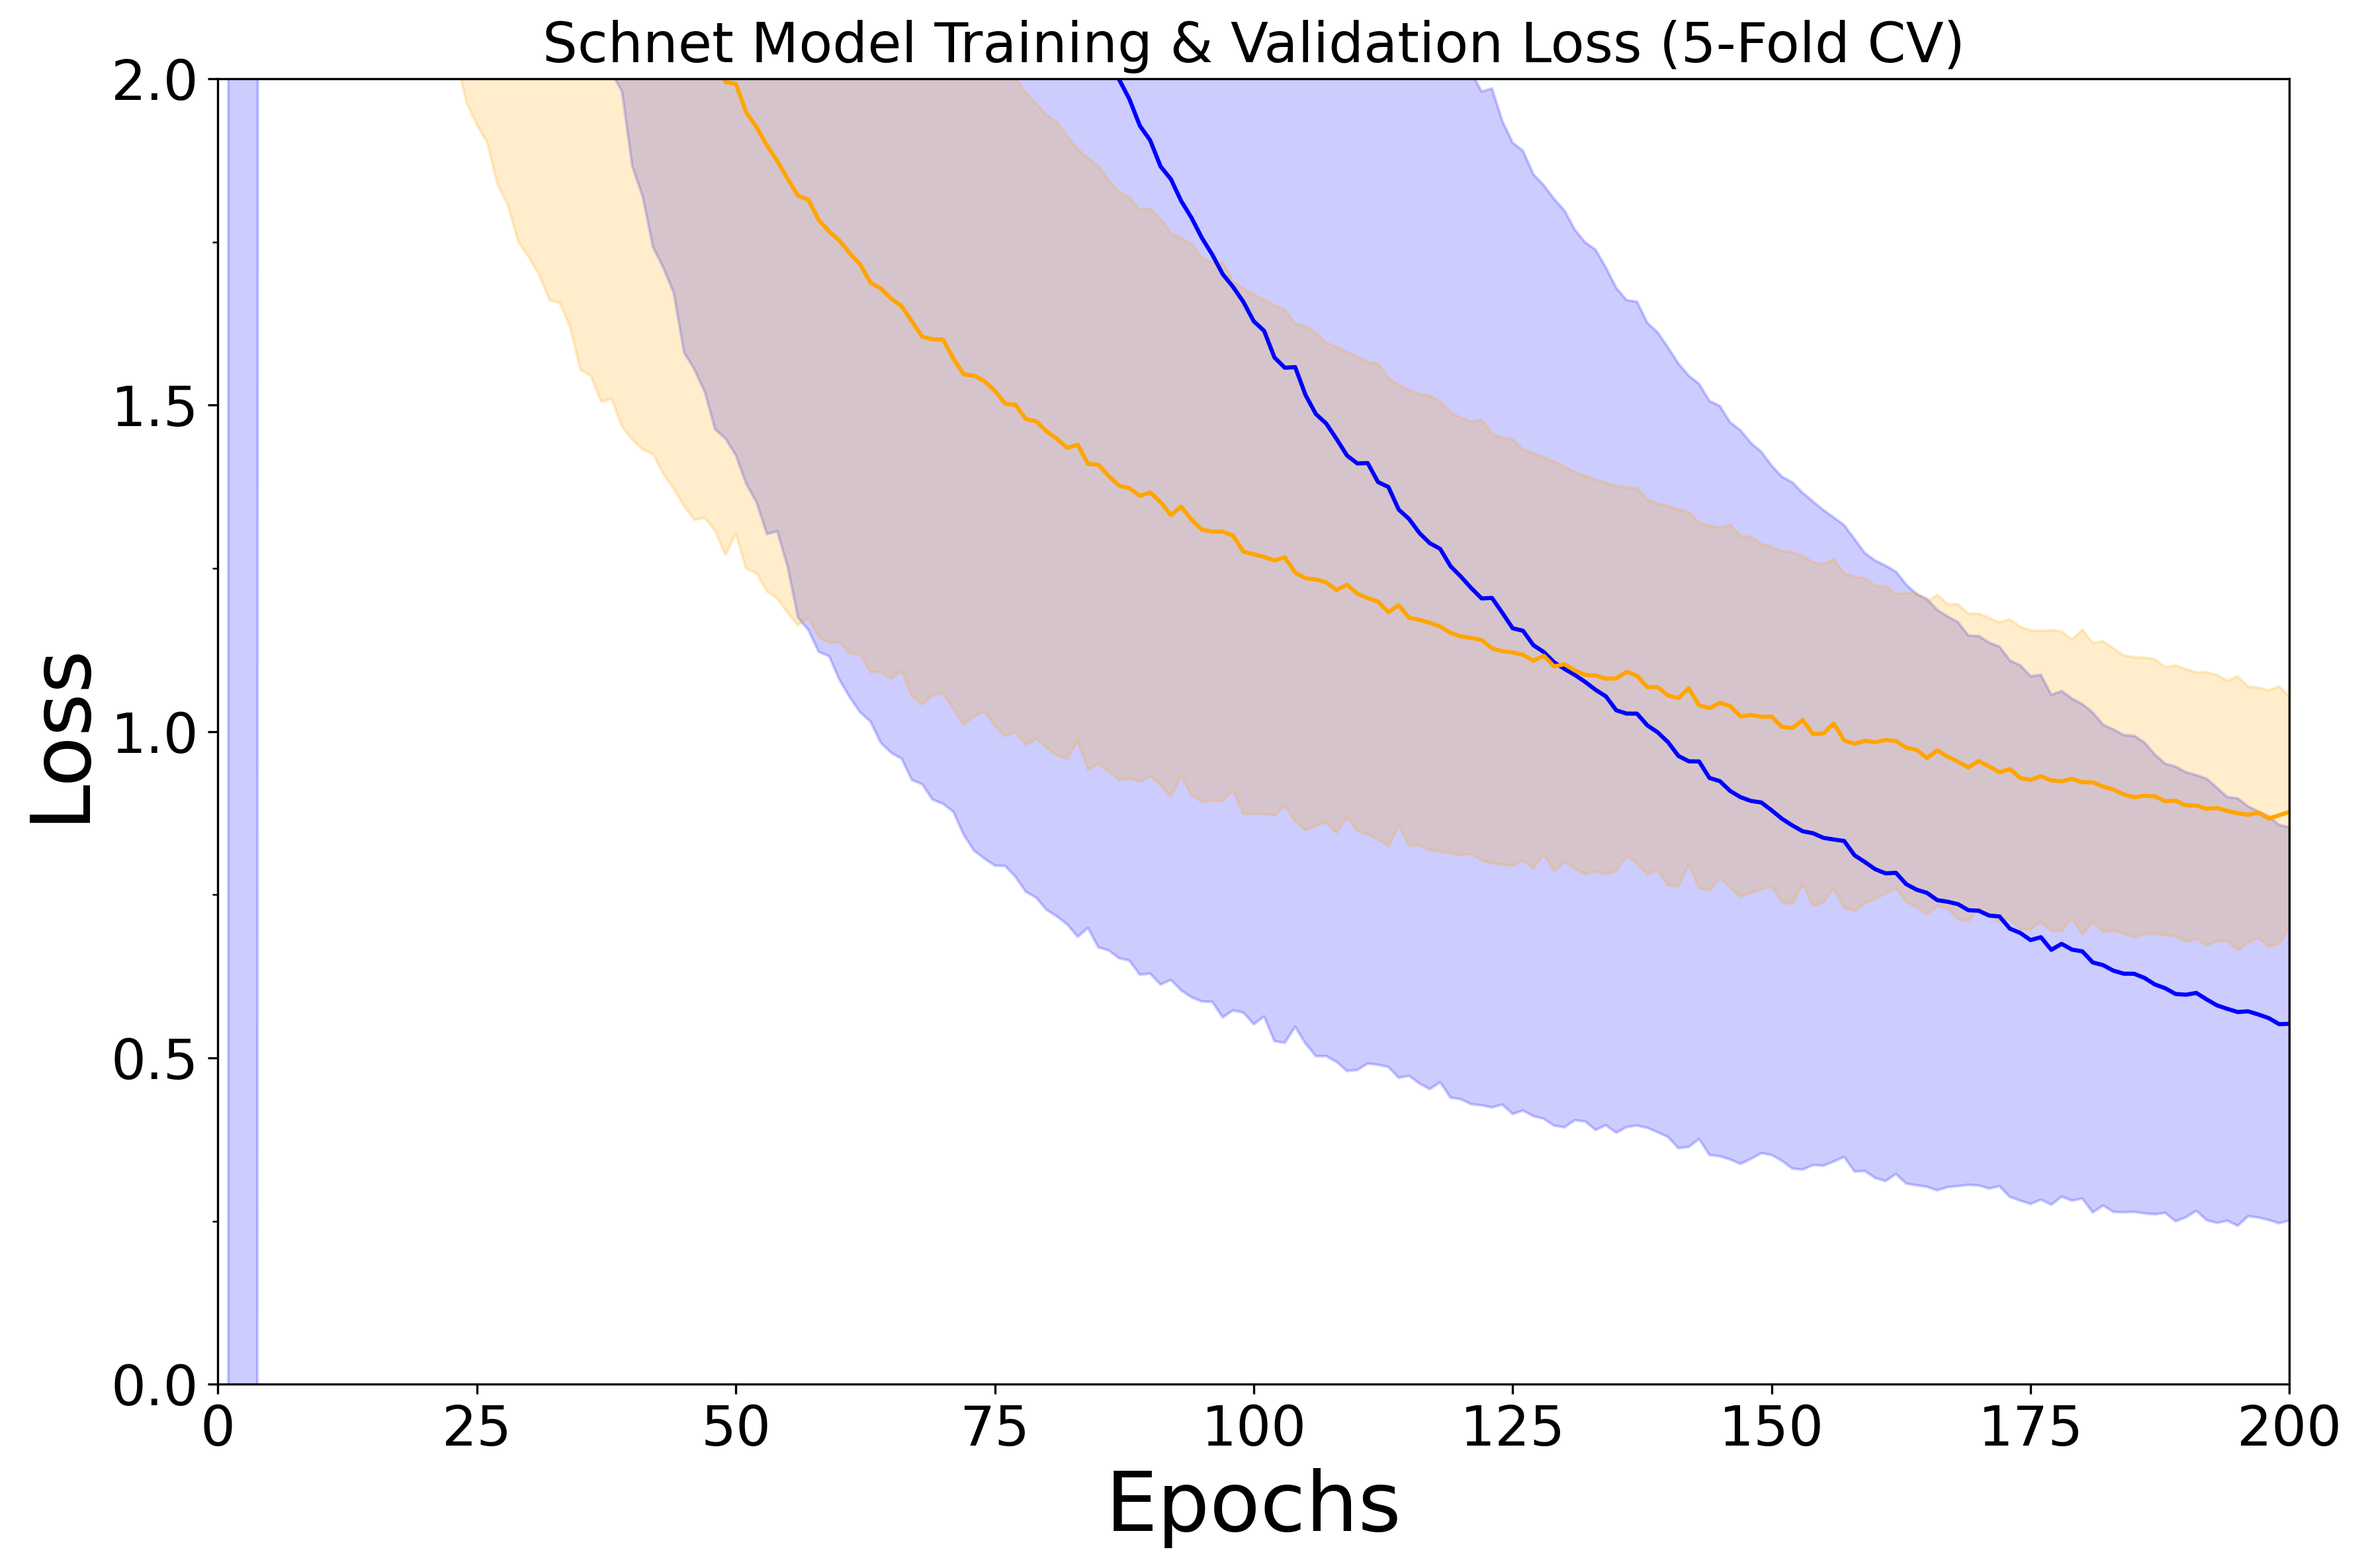

In [ ]:
# --- Plot Average Loss Curves ---
plt.figure(figsize=(12, 8),dpi=300)

max_epochs_run = max(len(losses) for losses in all_val_losses_cv) if all_val_losses_cv else args.epochs

padded_train_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_train_losses_cv]
padded_val_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_val_losses_cv_rmse] #all_val_losses_cv]

avg_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)
avg_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

epochs_axis = range(1, max_epochs_run + 1)

plt.plot(epochs_axis, avg_train_loss, label='Train Loss (MSE)', color='blue')
plt.fill_between(epochs_axis, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

plt.plot(epochs_axis, avg_val_loss, label=f'Validation Loss (RMSE)', color='orange')
plt.fill_between(epochs_axis, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)

plt.title(f'Schnet Model Training & Validation Loss ({k_folds}-Fold CV)', fontsize=20)
plt.xlabel('Epochs', fontsize=30)
plt.ylabel('Loss', fontsize=30)
#plt.legend(fontsize=30)
#plt.grid(True)
plt.xlim(0, max_epochs_run)
min_loss_val = np.nanmin(avg_val_loss - std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 0
max_loss_val = np.nanmax(avg_val_loss + std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 1
min_loss_train = np.nanmin(avg_train_loss - std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 0
max_loss_train = np.nanmax(avg_train_loss + std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 1
plt.ylim(0, 2) #max(max_loss_val, max_loss_train) * 1.1)
plt.yticks(np.arange(0, 2.1, 0.5))

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=20)
# add 1 minor ticks between each major tick
ax = plt.gca()
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.savefig('../Figures/SCHNET_kfold-cv.png', transparent=True, bbox_inches='tight')



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import math # For loss plot adjustment


# define the optimizer and 
import copy

# --- Prepare for K-Fold on Entire Dataset ---

print("--- Preparing for K-Fold Cross-Validation on Entire Dataset ---")
labels_for_stratification = []
for data in final_df.y:
    y_value = data
    if y_value < 0:
        labels_for_stratification.append(-1)
    else:
        labels_for_stratification.append(1)

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
print("Original Label Distribution:", Counter(labels_for_stratification))

indices = np.array(list(range(len(final_df)))) # Use NumPy array for easier indexing with KFold output
labels_for_stratification = np.array(labels_for_stratification) # Also NumPy array

# --- K-Fold Cross-Validation Setup ---

k_folds = 3 # Number of folds (e.g., 5 or 10)
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics from each fold
fold_best_val_rmses = []
fold_best_val_mses = [] # Store best validation MSE for each fold
all_train_losses_cv = [] # Store training losses for each fold
all_val_losses_cv = []   # Store validation losses for each fold
all_val_losses_cv_rmse = []   # Store validation losses for each fold

print(f'\n--- Starting {k_folds}-Fold Cross-Validation ---')

# --- K-Fold Loop ---
# Use the full indices and labels for splitting
for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(indices, labels_for_stratification)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # --- Get Original Indices for this Fold (Directly from KFold output) ---
    original_train_fold_indices = indices[train_fold_idx]
    original_val_fold_indices = indices[val_fold_idx]

    # --- Create Data for this Fold ---

    # get train df
    train_fold_df = final_df.iloc[original_train_fold_indices]
    
    '''# get mask for mfp from train data
    target_y = train_fold_df['y'].values
    descriptors = None
    for i,mol in enumerate(train_fold_df['mol']):
        x = compute_morgan_fingerprint(mol)
        if i == 0:
            descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
        descriptors[i]=x
    mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
    mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)'''
    
    # get val df
    val_fold_df = final_df.iloc[original_val_fold_indices]
    
    # Generate graph data
    train_fold_data = GenGraphs(train_fold_df) #, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_train_fold_indices]
    val_fold_data = GenGraphs(val_fold_df) #, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_val_fold_indices]
    
    num_node_features = train_fold_data[0].x.size(1)
    num_edge_features = train_fold_data[0].edge_attr.size(1)
    print(f"Number of node features: {num_node_features}")
    print(f"Number of edge features: {num_edge_features}")
    print(f'Fold {fold+1} - Train size: {len(train_fold_data)}, Validation size: {len(val_fold_data)}')

    # train args
    args = TrainArgsSchNet(hidden_channels=256, num_filters=256, num_interactions=10)

    # --- Create DataLoaders for this Fold ---
    train_fold_loader = DataLoader(train_fold_data, batch_size=args.batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_data, batch_size=args.batch_size, shuffle=False)

    # --- Re-initialize Model, Optimizer, and Scheduler for each fold ---
    print(f'Fold {fold+1} - Initializing model, optimizer, scheduler...')

    # Create the Schnet model directly
    model = SchNet(
        hidden_channels=args.hidden_channels,
        num_filters=args.num_filters,
        num_interactions=args.num_interactions,
        num_gaussians=args.num_gaussians,
        cutoff=args.cutoff,
        readout=args.readout,   # e.g., 'add' or 'mean'
        dipole=args.dipole,     # Usually False for general regression
        mean=args.mean,         # Usually None unless doing specific QM9 tasks
        std=args.std,           # Usually None
        atomref=args.atomref    # Usually None unless doing specific QM9 tasks
    ).to(device)

    params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
    optimizer = optim.Adam(params)
    criterion = torch.nn.MSELoss()
    rmse_loss = RmseLoss()

    scheduler = NoamLR(
        optimizer=optimizer,
        warmup_epochs=[args.warmup_epochs],
        total_epochs=[args.epochs] * args.num_lrs,
        steps_per_epoch=len(train_fold_loader) // args.batch_size,
        init_lr=[args.init_lr],
        max_lr=[args.max_lr],
        final_lr=[args.final_lr]
    )

    # --- Training Loop for this Fold ---
    patience = args.patience
    best_val_loss_fold = float('inf')
    patience_counter_fold = 0
    best_model_state_fold = None 
    best_epoch_fold = -1

    train_losses_fold = []
    val_losses_fold = [] # Store MSE
    val_losses_rmse_fold = [] # Store RMSE

    print(f'Fold {fold+1} - Starting training...')
    for epoch in range(1, args.epochs + 1):
        # Use MSE for training gradients, RMSE for validation metric
        train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse') 
        val_loss_mse = evaluate(val_fold_loader, model=model) 
        val_loss_rmse = evaluate_rmse(val_fold_loader, model=model) 
        current_val_loss = val_loss_rmse # Use RMSE for early stopping

        train_losses_fold.append(train_loss)
        val_losses_fold.append(val_loss_mse)
        val_losses_rmse_fold.append(val_loss_rmse)

        if epoch % 5 == 0 or epoch == 1: # Print less frequently
            print(f'  Epoch: {epoch:d}, Loss - Train: {train_loss:.5f}, Val MSE: {val_loss_mse:.5f}, Val RMSE: {val_loss_rmse:.5f}')

        # --- Early Stopping Check for this Fold ---
        improved = False
        if current_val_loss < best_val_loss_fold:
            best_val_loss_fold = current_val_loss
            improved = True

        if improved:
            patience_counter_fold = 0
            best_model_state_fold = copy.deepcopy(model.state_dict())
            best_epoch_fold = epoch
            # print(f'    -> Fold {fold+1} Val loss improved to {best_val_loss_fold:.5f}. Saving state.')
        else:
            patience_counter_fold += 1
            # print(f'    -> Fold {fold+1} Val metric did not improve. Patience: {patience_counter_fold}/{patience}')

        #if patience_counter_fold >= patience:
        #    print(f'  !!! Fold {fold+1} Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch_fold} with Val RMSE: {best_val_loss_fold:.5f}')
        #    break

    # --- Store performance for this fold ---
    if best_epoch_fold != -1: # Check if training improved at all
         fold_best_val_rmses.append(best_val_loss_fold)
         fold_best_val_mses.append(val_losses_fold[best_epoch_fold - 1]) # Store MSE at best epoch
         print(f'Fold {fold+1} - Finished. Best Validation RMSE: {best_val_loss_fold:.5f} (at Epoch {best_epoch_fold})')
         print(f'Fold {fold+1} - Best Validation MSE: {val_losses_fold[best_epoch_fold - 1]:.5f} (at Epoch {best_epoch_fold})')
    else:
         print(f'Fold {fold+1} - Finished. Validation loss did not improve.')
         # Decide how to handle this: append NaN, append last loss, or skip? NaN is often best for averaging.
         fold_best_val_rmses.append(float('nan'))

    # Store losses for plotting average curves
    all_train_losses_cv.append(train_losses_fold)
    all_val_losses_cv.append(val_losses_fold)
    all_val_losses_cv_rmse.append(val_losses_rmse_fold)

# --- Aggregate and Report Results ---
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')


print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Preparing for K-Fold Cross-Validation on Entire Dataset ---
Extracted 814 labels for stratification.
Original Label Distribution: Counter({1: 708, -1: 106})

--- Starting 3-Fold Cross-Validation ---

===== Fold 1/3 =====
Number of node features: 119
Number of edge features: 10
Fold 1 - Train size: 542, Validation size: 272
Fold 1 - Initializing model, optimizer, scheduler...
Fold 1 - Starting training...


C:\Users\fbhuiyan\AppData\Local\Temp\ipykernel_12468\4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
C:\Users\fbhuiyan\AppData\Local\Temp\ipykernel_12468\4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 116.91953, Val MSE: 27.92205, Val RMSE: 5.27360
  Epoch: 5, Loss - Train: 9.54374, Val MSE: 6.53328, Val RMSE: 2.54064
  Epoch: 10, Loss - Train: 4.09028, Val MSE: 3.28944, Val RMSE: 1.80458
  Epoch: 15, Loss - Train: 2.93512, Val MSE: 2.51037, Val RMSE: 1.57926
  Epoch: 20, Loss - Train: 2.29032, Val MSE: 2.06834, Val RMSE: 1.43577
  Epoch: 25, Loss - Train: 1.86944, Val MSE: 1.75176, Val RMSE: 1.32169
  Epoch: 30, Loss - Train: 1.54910, Val MSE: 1.49965, Val RMSE: 1.22275
  Epoch: 35, Loss - Train: 1.34745, Val MSE: 1.30388, Val RMSE: 1.13979
  Epoch: 40, Loss - Train: 1.18518, Val MSE: 1.22735, Val RMSE: 1.10487
  Epoch: 45, Loss - Train: 1.00623, Val MSE: 1.06403, Val RMSE: 1.02915
  Epoch: 50, Loss - Train: 0.90776, Val MSE: 0.96001, Val RMSE: 0.97640
Fold 1 - Finished. Best Validation RMSE: 0.97640 (at Epoch 50)
Fold 1 - Best Validation MSE: 0.96001 (at Epoch 50)

===== Fold 2/3 =====
Number of node features: 119
Number of edge features: 10
Fold 2 - Trai

In [15]:

print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Cross-Validation Summary ---
Average Best Validation RMSE across 3 folds: 1.45467 ± 0.44165
Average Best Validation MSE across 3 folds: 2.33267 ± 1.37099

Individual Fold Best Validation RMSEs (MSEs):
  Fold 1: 0.97640 (MSE: 0.96001)
  Fold 2: 1.34591 (MSE: 1.83314)
  Fold 3: 2.04170 (MSE: 4.20487)


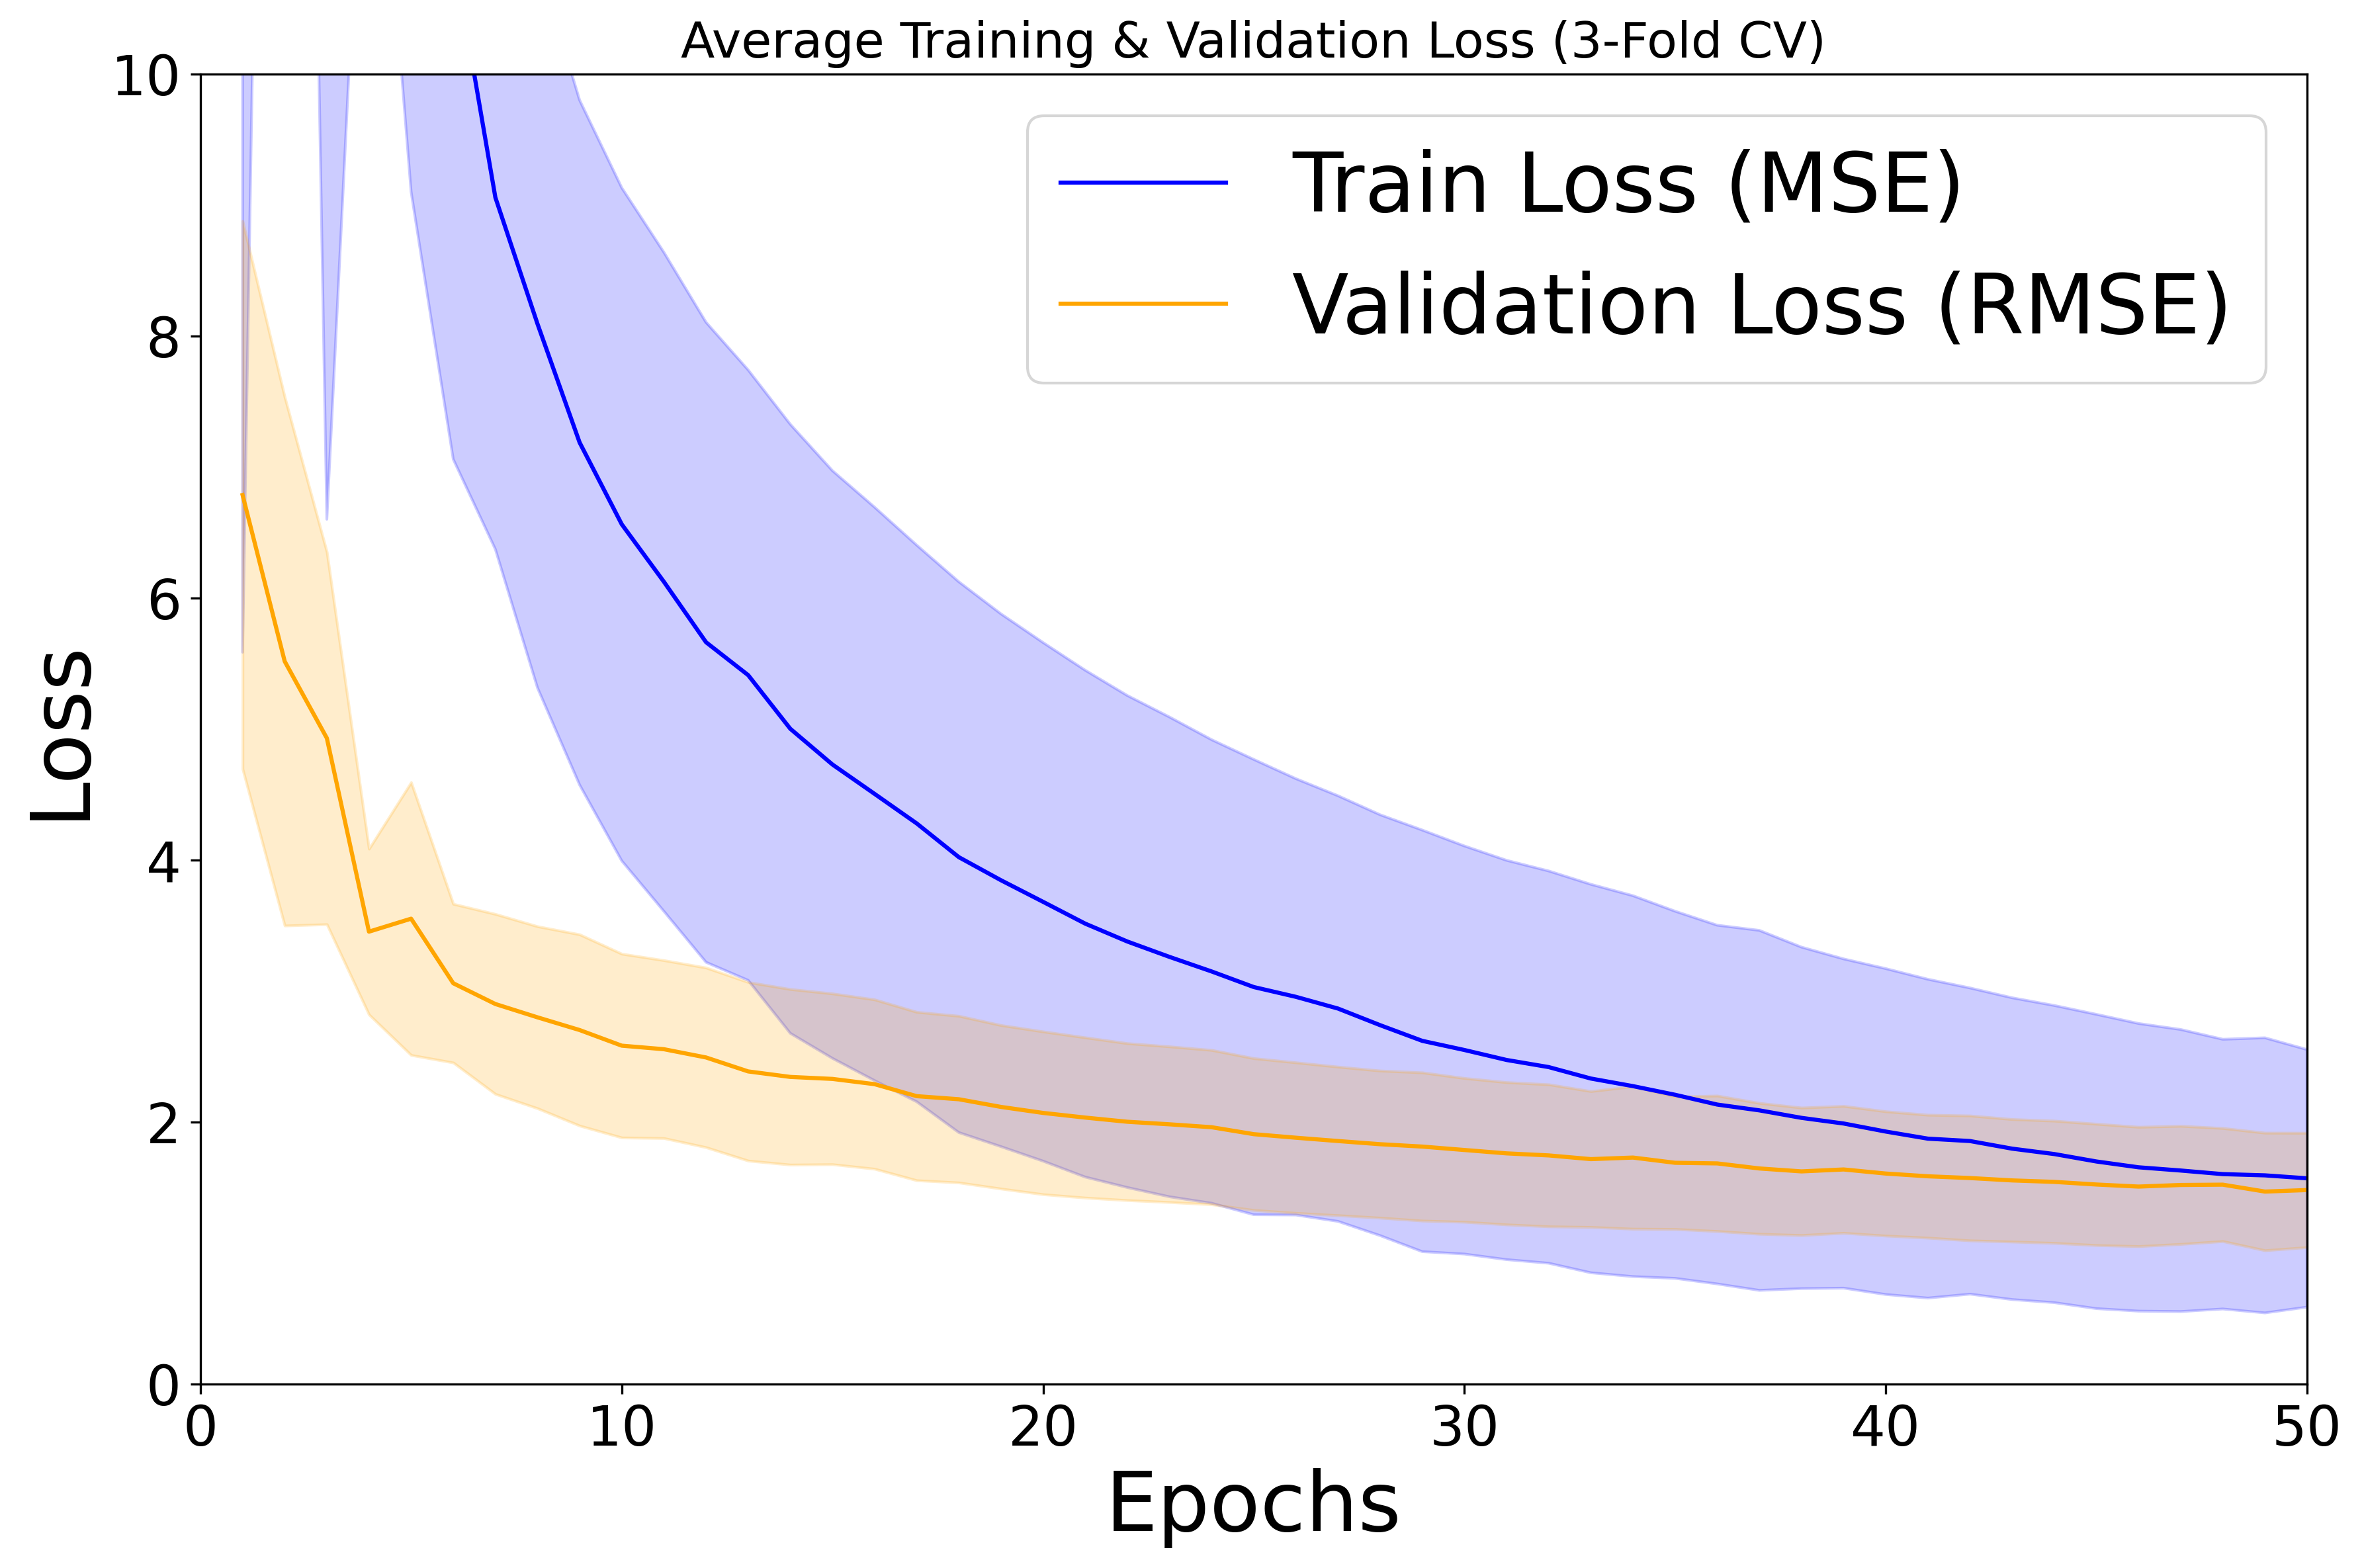

In [16]:
# --- Plot Average Loss Curves ---
plt.figure(figsize=(12, 8),dpi=300)

max_epochs_run = max(len(losses) for losses in all_val_losses_cv) if all_val_losses_cv else args.epochs

padded_train_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_train_losses_cv]
padded_val_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_val_losses_cv_rmse] #all_val_losses_cv]

avg_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)
avg_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

epochs_axis = range(1, max_epochs_run + 1)

plt.plot(epochs_axis, avg_train_loss, label='Train Loss (MSE)', color='blue')
plt.fill_between(epochs_axis, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

plt.plot(epochs_axis, avg_val_loss, label=f'Validation Loss (RMSE)', color='orange')
plt.fill_between(epochs_axis, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)

plt.title(f'Average Training & Validation Loss ({k_folds}-Fold CV)', fontsize=18)
plt.xlabel('Epochs', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.legend(fontsize=30)
#plt.grid(True)
plt.xlim(0, max_epochs_run)
min_loss_val = np.nanmin(avg_val_loss - std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 0
max_loss_val = np.nanmax(avg_val_loss + std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 1
min_loss_train = np.nanmin(avg_train_loss - std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 0
max_loss_train = np.nanmax(avg_train_loss + std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 1
plt.ylim(0, 10)

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()



# Final rep model

In [10]:
# Data splitting

from torch_geometric.loader import DataLoader
import random
from sklearn.model_selection import train_test_split

labels_for_stratification = [] #[data.y.item() for data in graph_data]
for data in final_df.y:
    y_value = data
    # Assign label based on the sign of the value
    if y_value < 0:
        labels_for_stratification.append(-1) # Assign -1 for negative values
    else: # Includes y_value >= 0 (including exactly 0)
        labels_for_stratification.append(1)  # Assign +1 for non-negative values

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
# Optional: Check label distribution
from collections import Counter
print("Original Label Distribution:", Counter(labels_for_stratification))


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15 # train + val + test = 1.0

# Indices for splitting data and labels together
indices = list(range(len(final_df)))

# First split: Separate Test set, stratifying by the labels
train_val_indices, test_indices, y_train_val, y_test_unused = train_test_split(
    indices, # Split indices first
    labels_for_stratification, # Labels corresponding to indices
    test_size=test_ratio,
    shuffle=True, # Shuffle before splitting
    stratify=labels_for_stratification, # Stratify based on the full label list
    random_state=42
)

# Second split: Separate Train and Validation sets from the train_val pool
# Stratify based on the labels remaining in the train_val pool (y_train_val)
# Calculate the validation proportion relative to the train_val pool size
val_proportion_of_train_val = val_ratio / (train_ratio + val_ratio)

train_indices, val_indices, y_train_unused, y_val_unused = train_test_split(
    train_val_indices, # Split the indices reserved for train/val
    y_train_val,       # Labels corresponding to train_val_indices
    test_size=val_proportion_of_train_val,
    shuffle=True, # shuffle False does not work with stratification lol
    stratify=y_train_val, # Stratify based on the train_val labels
    random_state=42 # Can use same state or different
)

# Create the final data splits using the selected indices

# get train df
train_fold_df = final_df.iloc[train_indices]

# No need to compute mfp for dimenet
'''# get mask for mfp from train data
target_y = train_fold_df['y'].values
descriptors = None
for i,mol in enumerate(train_fold_df['mol']):
    x = compute_morgan_fingerprint(mol)
    if i == 0:
        descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
    descriptors[i]=x
mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)'''

# get val and test df
val_fold_df = final_df.iloc[val_indices]
test_fold_df = final_df.iloc[test_indices]

# Generate graph data
train_data = GenGraphs(train_fold_df)
val_data = GenGraphs(val_fold_df)
test_data = GenGraphs(test_fold_df)

num_node_features = train_data[0].x.size(1)
num_edge_features = train_data[0].edge_attr.size(1)

# --- Verification ---
print(f'\n--- Split Sizes ---')
print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')
print(f'Total: {len(train_data) + len(val_data) + len(test_data)} (should match original)')

print(f'\n--- Class Distribution Verification ---')
train_labels_orig = [d.y.item() for d in train_data]
val_labels_orig = [d.y.item() for d in val_data]
test_labels_orig = [d.y.item() for d in test_data]
# You might want to check the +/- ratio in the *original* y values for each split
# to see how well stratification worked
print(f"Train +/- ratio: {sum(1 for y in train_labels_orig if y>=0)} / {sum(1 for y in train_labels_orig if y<0)}")
print(f"Val +/- ratio: {sum(1 for y in val_labels_orig if y>=0)} / {sum(1 for y in val_labels_orig if y<0)}")
print(f"Test +/- ratio: {sum(1 for y in test_labels_orig if y>=0)} / {sum(1 for y in test_labels_orig if y<0)}")


Extracted 1450 labels for stratification.
Original Label Distribution: Counter({1: 1239, -1: 211})

--- Split Sizes ---
Train size: 1014
Validation size: 218
Test size: 218
Total: 1450 (should match original)

--- Class Distribution Verification ---
Train +/- ratio: 867 / 147
Val +/- ratio: 186 / 32
Test +/- ratio: 186 / 32


In [11]:
class TrainArgsSchNet:
    def __init__(self,
                 # SchNet specific hyperparameters
                 hidden_channels=128,    # Hidden embedding size
                 num_filters=128,        # Number of filters (often same as hidden_channels)
                 num_interactions=6,     # Number of interaction blocks (like GNN layers)
                 num_gaussians=50,       # Number of Gaussians for distance expansion
                 cutoff=8.0,            # Cutoff distance for interactions
                 # Optional SchNet args from its __init__ if you need them:
                 # interaction_graph=None, # Custom graph generation function
                 # max_num_neighbors=32,   # If not using custom interaction_graph
                 readout='add',          # Aggregation for final output ('add' or 'mean')
                 dipole=False,           # Specific to dipole moment prediction
                 mean=None,              # For output standardization
                 std=None,               # For output standardization
                 atomref=None,           # Atomic reference energies

                 # General training args (kept the same as your DimeNetPP args)
                 batch_size=64,
                 init_lr=1e-4,
                 max_lr=1e-3,
                 final_lr=1e-5,
                 num_lrs=1,
                 warmup_epochs=2.0,
                 epochs=200,
                 patience=50):

        # Assign arguments to instance attributes
        # SchNet specific
        self.hidden_channels = hidden_channels
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.num_gaussians = num_gaussians
        self.cutoff = cutoff
        # self.interaction_graph = interaction_graph # Uncomment if using
        # self.max_num_neighbors = max_num_neighbors # Uncomment if using
        self.readout = readout
        self.dipole = dipole
        self.mean = mean
        self.std = std
        self.atomref = atomref

        # General training args
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.max_lr = max_lr
        self.final_lr = final_lr
        self.num_lrs = num_lrs
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.patience = patience


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# train args
args = TrainArgsSchNet()


# Create the DimeNetPlusPlus model directly
model = SchNet(
    hidden_channels=args.hidden_channels,
    num_filters=args.num_filters,
    num_interactions=args.num_interactions,
    num_gaussians=args.num_gaussians,
    cutoff=args.cutoff,
    # Optional SchNet parameters (can use defaults or values from args):
    # max_num_neighbors=32, # Default, can be omitted or set in args
    readout=args.readout,   # e.g., 'add' or 'mean'
    dipole=args.dipole,     # Usually False for general regression
    mean=args.mean,         # Usually None unless doing specific QM9 tasks
    std=args.std,           # Usually None
    atomref=args.atomref    # Usually None unless doing specific QM9 tasks
    # Note: SchNet's out_channels is implicitly 1 for standard regression use
    # via its internal self.lin2 = Linear(hidden_channels // 2, 1)
    # before the readout.
).to(device)

In [13]:
# define the optimizer and 
import copy

model = model
args = args

params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
optimizer = optim.Adam(params)
criterion = torch.nn.MSELoss()
rmse_loss = RmseLoss()

# DataLoaders
batch_size = args.batch_size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_loader_noshuffle = DataLoader(train_data, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created successfully.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_fold_loader) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)

# Early Stopping variables
patience = args.patience # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

#train  
train_losses = []
val_losses = []
val_losses_rmse = []
test_losses = []
for epoch in range(1, args.epochs + 1):
    # Use MSE for training gradients, RMSE for validation metric
    train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse') # Assuming train uses global 'model', 'optimizer', 'scheduler'
    val_loss = evaluate(val_fold_loader, model=model) # Assuming evaluate uses global 'model'
    val_loss_rmse = evaluate_rmse(val_fold_loader, model=model) # Assuming evaluate_rmse uses global 'model'
    current_val_loss = val_loss_rmse # Use RMSE for early stopping
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_losses_rmse.append(val_loss_rmse)

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:d}, Loss - Train: {train_loss:.7f}, Val MSE: {val_loss:.7f}, Val RMSE: {val_loss_rmse:.7f}')

    # --- Early Stopping Check ---
    if epoch > 0:
        improved = False
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            improved = True

        if improved:
            patience_counter = 0 # Reset patience
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            print(f'   -> Validation loss improved to {best_val_loss:.7f}. Saving model state.')
        else:
            patience_counter += 1
            print(f'   -> Validation metric did not improve. Patience: {patience_counter}/{patience}')

        if patience_counter >= patience:
            print(f'!!! Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch} with Val Loss: {best_val_loss:.5f}')
            break # Exit the training loop

# --- After Training Loop ---
# Load the best model state found during training
if best_model_state:
    print("Loading best model state for final evaluation.")
    model.load_state_dict(best_model_state)
    # model.load_state_dict(torch.load('best_model.pth')) # If saved to disk
else:
    print("Warning: No best model state saved (perhaps training ended too early or validation loss never improved).")

# Final evaluation on the test set using the best model
print("Evaluating final model on Test Set...")
final_train_mse = evaluate(train_loader, model=model)
final_train_rmse = evaluate_rmse(train_loader, model=model)
final_val_mse = evaluate(val_loader, model=model)
final_val_rmse = evaluate_rmse(val_loader, model=model)
final_test_mse = evaluate(test_loader, model=model)
final_test_rmse = evaluate_rmse(test_loader, model=model)
print(f'Final Train Loss (best model): MSE {final_train_mse:.4f}, RMSE {final_train_rmse:.4f}')
print(f'Final Val Loss (best model): MSE {final_val_mse:.4f}, RMSE {final_val_rmse:.4f}')
print(f'Final Test Loss (best model): MSE {final_test_mse:.4f}, RMSE {final_test_rmse:.4f}')


DataLoaders created successfully.
Using device: cuda


/var/tmp/pbs.83507.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_1251080/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.83507.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_1251080/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


Epoch: 1, Loss - Train: 84.3386860, Val MSE: 67.2520930, Val RMSE: 8.1949517
   -> Validation loss improved to 8.1949517. Saving model state.
Epoch: 2, Loss - Train: 52.8180781, Val MSE: 48.1829980, Val RMSE: 6.9353312
   -> Validation loss improved to 6.9353312. Saving model state.
Epoch: 3, Loss - Train: 39.9541930, Val MSE: 37.8720647, Val RMSE: 6.1484478
   -> Validation loss improved to 6.1484478. Saving model state.
Epoch: 4, Loss - Train: 31.8697963, Val MSE: 30.4051051, Val RMSE: 5.5031033
   -> Validation loss improved to 5.5031033. Saving model state.
Epoch: 5, Loss - Train: 26.1399397, Val MSE: 24.8609284, Val RMSE: 4.9707561
   -> Validation loss improved to 4.9707561. Saving model state.
Epoch: 6, Loss - Train: 22.0314778, Val MSE: 20.5509577, Val RMSE: 4.5138638
   -> Validation loss improved to 4.5138638. Saving model state.
Epoch: 7, Loss - Train: 18.8075681, Val MSE: 17.6123254, Val RMSE: 4.1734442
   -> Validation loss improved to 4.1734442. Saving model state.
Epoch:

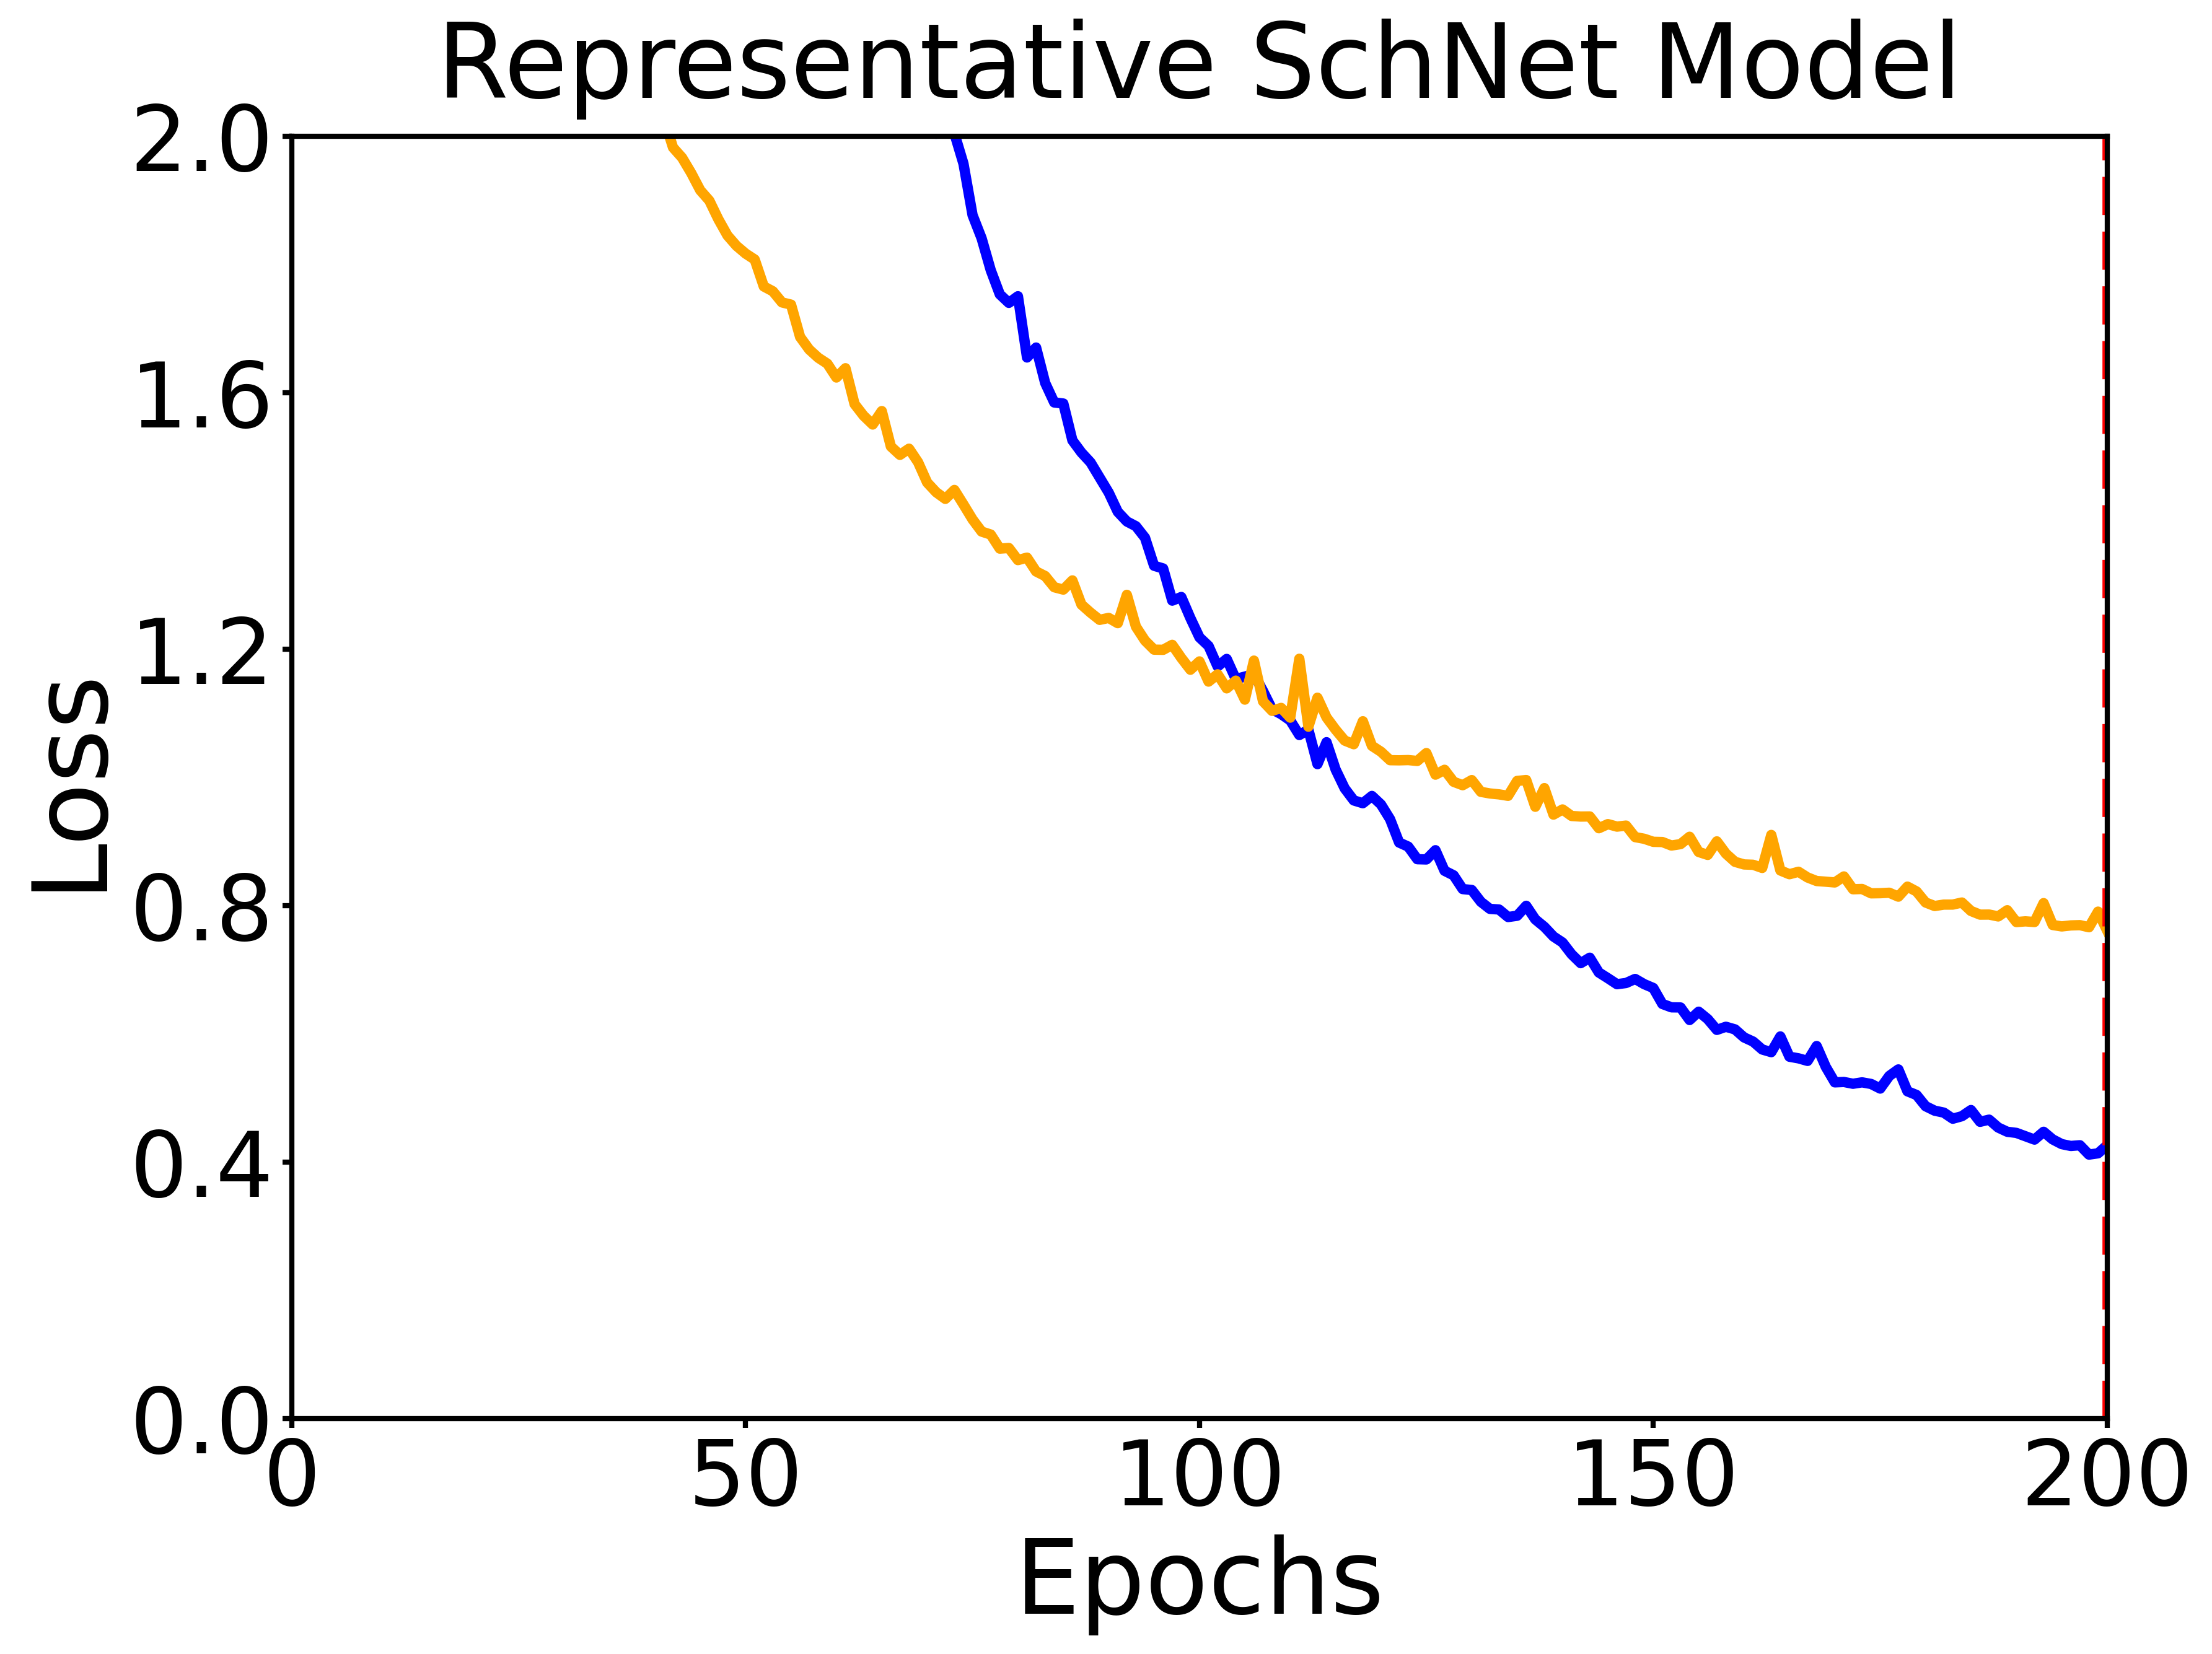

In [16]:
import math

# visualize the loss as the network trained
fig, ax = plt.subplots(figsize=(12,9),dpi=300) # Slightly larger figure for bigger fonts

for spine in ax.spines.values():
    spine.set_linewidth(2)  # Change 2 to desired thickness

epochs = list(range(1, len(train_losses) + 1)) # X-axis data
data = {
    'epoch': epochs,
    'training_loss_(mse)': train_losses
}
data_df = pd.DataFrame(data)
output_filepath = "../Figures/Sch_rep-model.txt"
data_df.to_csv(output_filepath, index=False)

plt.plot(epochs,train_losses, c='b', label='Training Loss (MSE)', linewidth=4)
plt.plot(epochs,val_losses_rmse, c='orange', label='Validation Loss (RMSE)', linewidth=4)

if best_epoch != -1: # Indicate best epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=4)

# --- Fontsize Modifications ---
plt.title('Representative SchNet Model', fontsize=40, pad=15) # Increased title fontsize
plt.xlabel('Epochs', fontsize=40) # Increased x-label fontsize
plt.ylabel('Loss', fontsize=40) # Increased y-label fontsize
#plt.legend(fontsize=32, loc='upper left') # Increased legend fontsize
plt.tick_params(axis='both', which='major', width=2, labelsize=35) # Increased tick label size

num_epochs_run = len(val_losses_rmse)
plt.xlim(0, 200)

plt.ylim(0, 2)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))

#plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig('../Figures/Sch_rep-model.png', transparent=True, bbox_inches='tight')
plt.show()

Plotting results and finding outliers with threshold = 0.8...
Processing Training data...
R² Score Train set: -0.015
Found and stored 203 outliers in Train set.
R² Score Validation set: -0.475
Found and stored 55 outliers in Validation set.
R² Score Test set: -0.308
Found and stored 54 outliers in Test set.

Total number of unique outliers found: 312
{ 16: {'pred': 0.9493513703346252, 'true': 1.7953169345855713},
  19: {'pred': 0.7469522953033447, 'true': -0.23146949708461761},
  24: {'pred': -0.6591553688049316, 'true': 0.3176577091217041},
  25: {'pred': 1.2860987186431885, 'true': 0.3877795338630676},
  30: {'pred': -0.7937992811203003, 'true': 0.42368870973587036},
  34: {'pred': 0.5268121957778931, 'true': 1.3372142314910889},
  36: {'pred': 0.520260751247406, 'true': 1.431102991104126},
  38: {'pred': 1.2317631244659424, 'true': 0.21705645322799683},
  46: {'pred': 1.3680644035339355, 'true': -0.49831295013427734},
  47: {'pred': 0.9720255136489868, 'true': -0.03187214955687523},

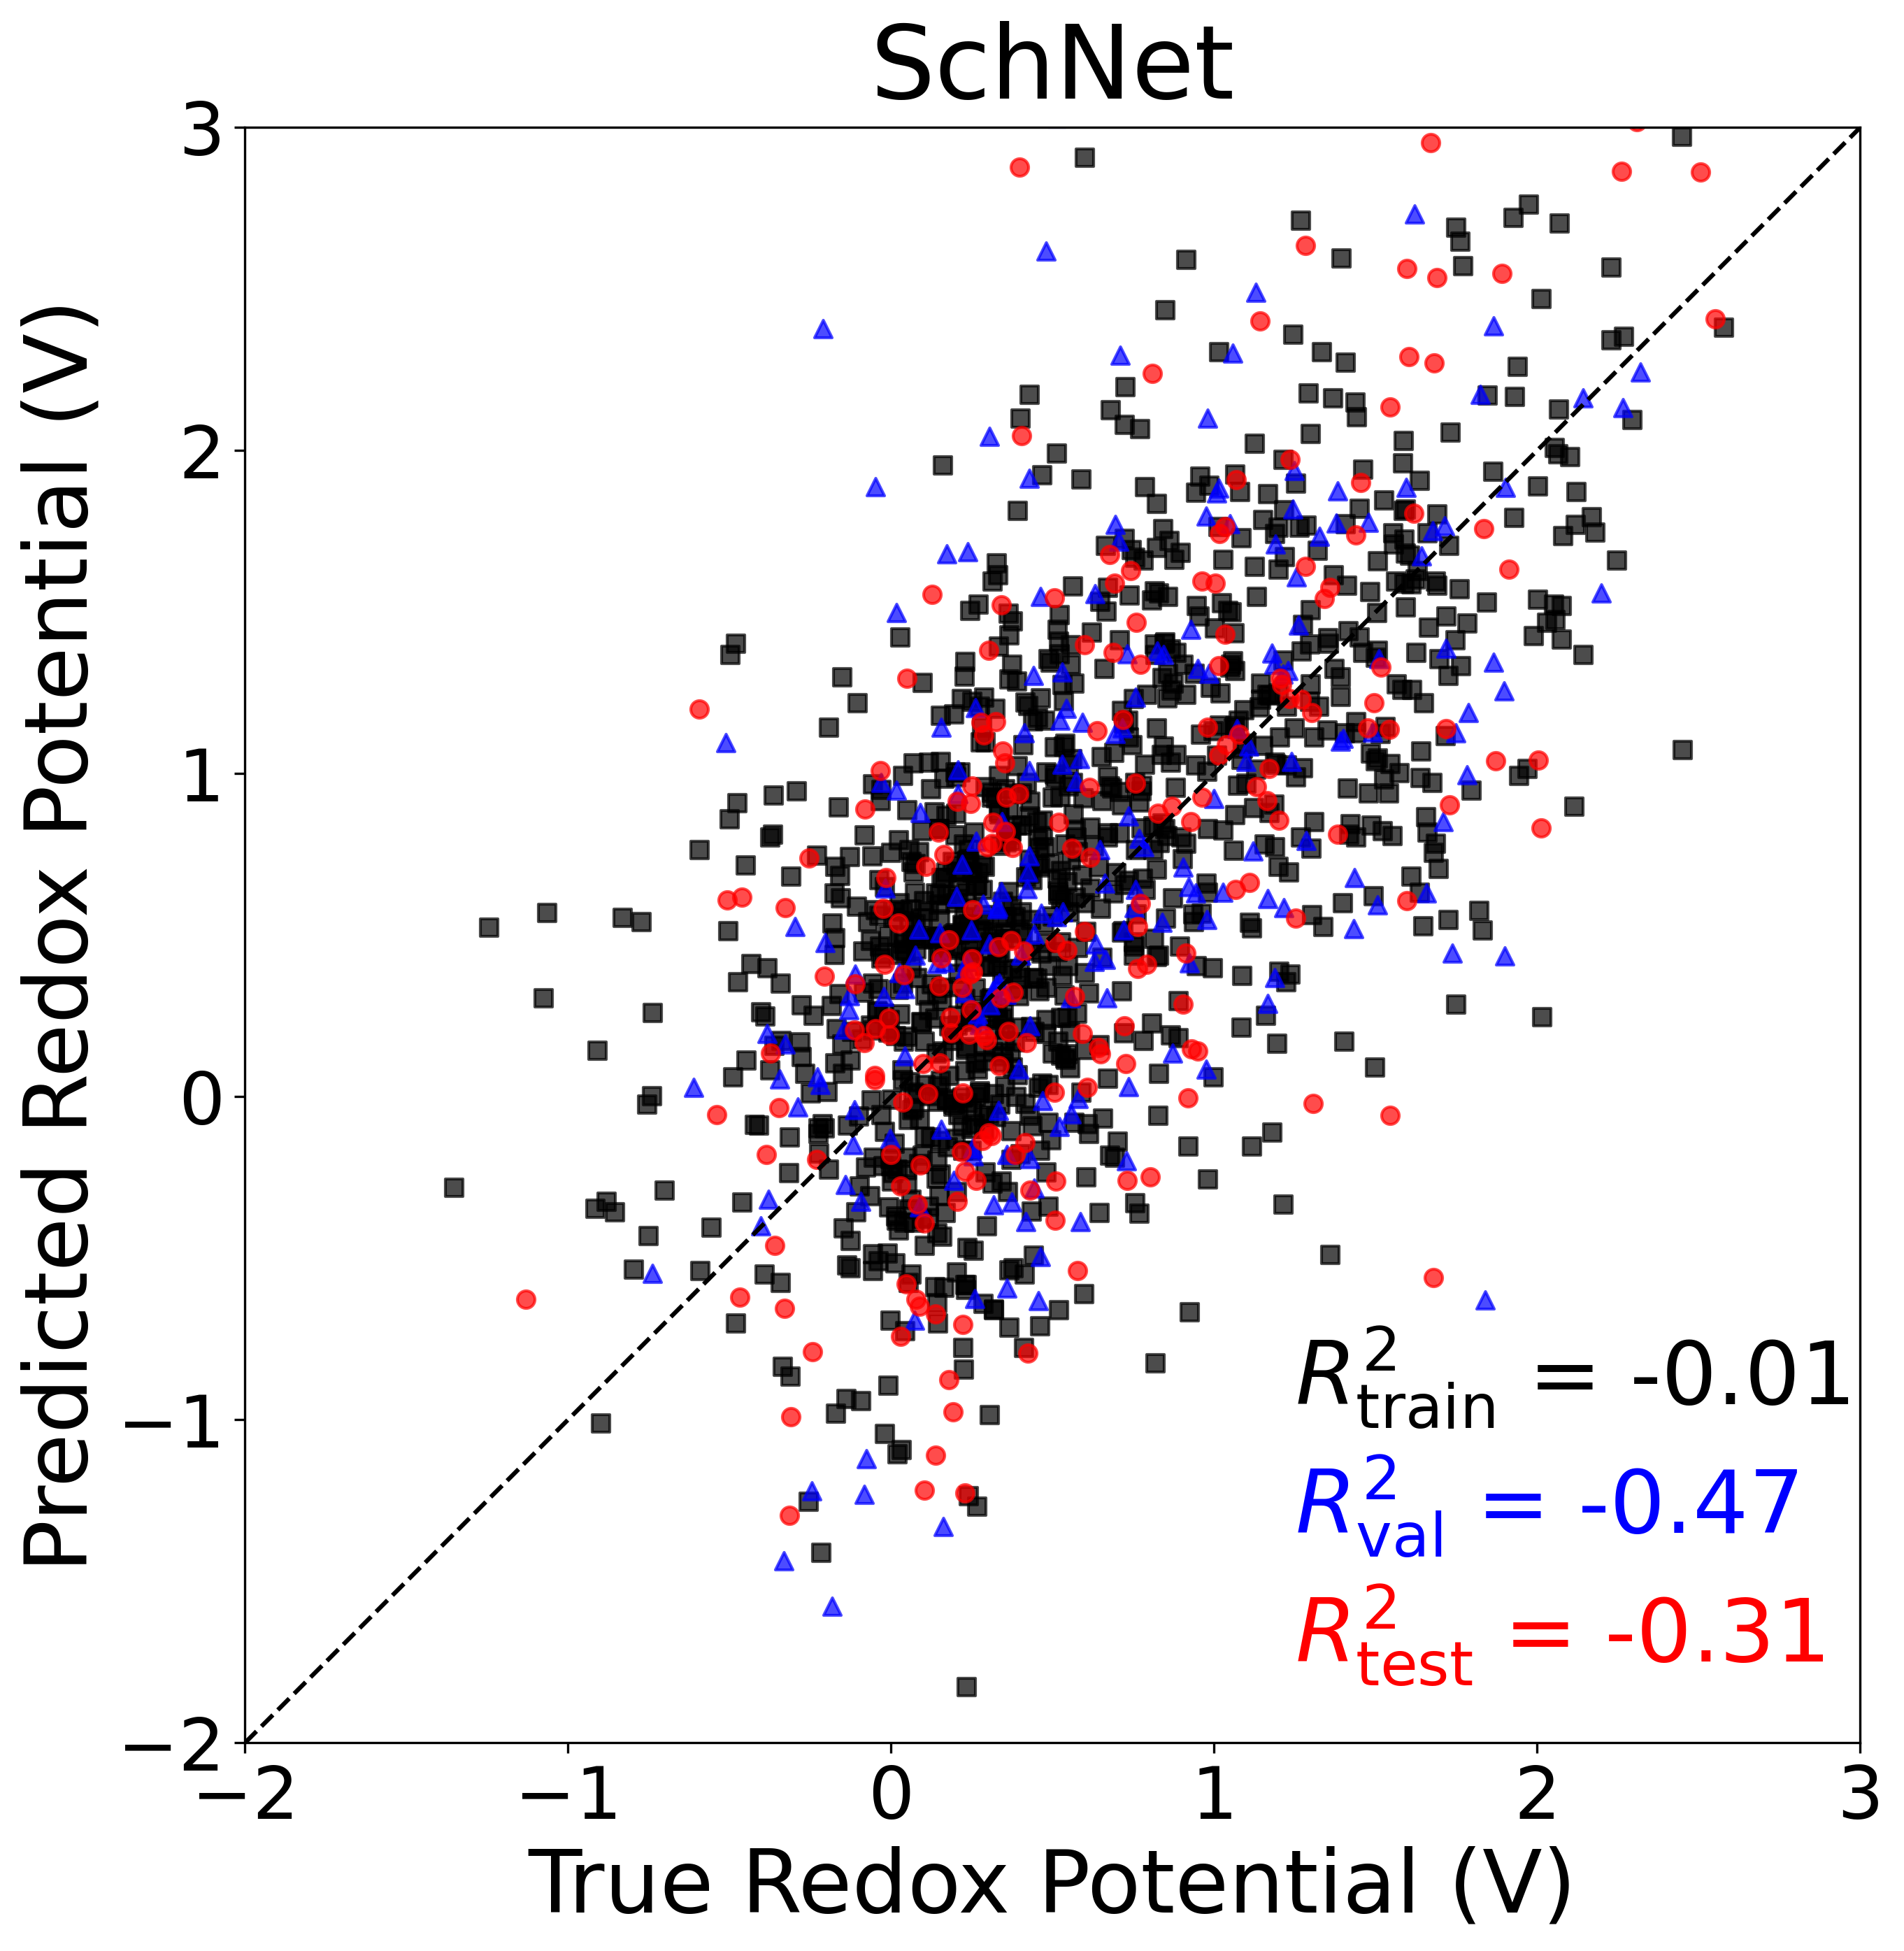

In [18]:
import pprint
import pandas as pd

# --- Configuration ---
outlier_threshold = 0.8

# --- Set model to evaluation mode ---
model.eval()

# --- Initialize dictionary for original outlier info ---
original_outlier_info = {} 
# Outliers are not plotted here

# --- Initialize Plotting ---
print(f"Plotting results and finding outliers with threshold = {outlier_threshold}...")
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

title_fontsize = 35
axlabel_fontsize = 30
ticklabel_fontsize = 25

# --------------------------------------------------
# Helper function to process a split (train/val/test)
# --------------------------------------------------
def process_split_dime_sch(loader, indices, split_name):
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            y_true.append(data.y)
            y_pred.append(model(z = data.z, pos = data.pos, batch = data.batch))
    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

    # Calculate R²
    r2_val = round(r2_score(y_true, y_pred), 3)
    print(f"R² Score {split_name} set: {r2_val}")

    # Identify outliers
    error = np.abs(y_true - y_pred)
    outlier_mask = error >= outlier_threshold
    split_outlier_indices = np.where(outlier_mask)[0]

    num_outliers = 0
    for split_idx in split_outlier_indices:
        original_idx = indices[split_idx]
        true_val = y_true[split_idx].item()
        pred_val = y_pred[split_idx].item()
        if original_idx not in original_outlier_info:
            original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
            num_outliers += 1
    print(f"Found and stored {num_outliers} outliers in {split_name} set.")

    return y_true, y_pred, r2_val

# --------------------------------------------------
# Process Train / Val / Test
# --------------------------------------------------
print("Processing Training data...")
if 'train_loader_noshuffle' not in locals():
    print("Warning: 'train_loader_noshuffle' not found. Creating one. Ensure train_data exists.")
    train_loader_noshuffle = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)

y_true_train, y_pred_train, r2_train = process_split_dime_sch(train_loader_noshuffle, train_indices, "Train")
y_true_val,   y_pred_val,   r2_val   = process_split_dime_sch(val_loader,   val_indices,   "Validation")
y_true_test,  y_pred_test,  r2_test  = process_split_dime_sch(test_loader,  test_indices,  "Test")

# --------------------------------------------------
# Plot all together
# --------------------------------------------------
ax.scatter(y_true_train, y_pred_train, color='black', alpha=0.7, marker='s', label='Train')
ax.scatter(y_true_val,   y_pred_val,   color='blue', alpha=0.7, marker='^', label='Validation')
ax.scatter(y_true_test,  y_pred_test,  color='red', alpha=0.7, marker='o', label='Test')

# Ideal line
ax.plot([-2, 3], [-2, 3], 'k--', linewidth=1.5) #, label='Ideal (y=x)')

# Labels, ticks, formatting
ax.set_xlabel("True Redox Potential (V)", fontsize=axlabel_fontsize)
ax.set_ylabel("Predicted Redox Potential (V)", fontsize=axlabel_fontsize)
ax.set_title("SchNet", fontsize=title_fontsize, pad=10)
ax.set_xlim(-2, 3)
ax.set_xticks(np.arange(-2, 3.1, 1))
ax.set_ylim(-2, 3)
ax.set_yticks(np.arange(-2, 3.1, 1))
ax.tick_params(axis='both', which='major', labelsize=ticklabel_fontsize)
ax.set_aspect('equal', adjustable='box')
#ax.legend(fontsize=30, loc='upper left', markerscale=2)

# Print R² values on plot (in matching colors)
ax.text(0.65, 0.21, r"$R^{2}_{\text{train}}$ = " + f"{r2_train:.2f}", transform=ax.transAxes, 
        ha='left', fontsize=30, color='black') # , bbox=dict(facecolor='white', alpha=0.8)
ax.text(0.65, 0.13, r"$R^{2}_{\text{val}}$ = " + f"{r2_val:.2f}", transform=ax.transAxes, 
        ha='left', fontsize=30, color='blue') # , bbox=dict(facecolor='white', alpha=0.8)
ax.text(0.65, 0.05, r"$R^{2}_{\text{test}}$ = " + f"{r2_test:.2f}", transform=ax.transAxes, 
        ha='left', fontsize=30, color='red') # , bbox=dict(facecolor='white', alpha=0.8)

# --------------------------------------------------
# Save data to files
# --------------------------------------------------
pd.DataFrame({
    'true': y_true_train.ravel(),
    'pred': y_pred_train.ravel()
}).to_csv("../Figures/SchNet_train_parity.txt", sep="\t", index=False)

pd.DataFrame({
    'true': y_true_val.ravel(),
    'pred': y_pred_val.ravel()
}).to_csv("../Figures/SchNet_val_parity.txt", sep="\t", index=False)

pd.DataFrame({
    'true': y_true_test.ravel(),
    'pred': y_pred_test.ravel()
}).to_csv("../Figures/SchNet_test_parity.txt", sep="\t", index=False)


# --------------------------------------------------
# Finalize
# --------------------------------------------------
sorted_outlier_info = dict(sorted(original_outlier_info.items()))
print(f"\nTotal number of unique outliers found: {len(sorted_outlier_info)}")
pprint.pprint(sorted_outlier_info, indent=2)

plt.savefig('../Figures/SchNet_parity.png', transparent=True, bbox_inches='tight')
plt.show()


Plotting results and finding outliers with threshold = 0.8...
Processing Training data...
R² Score Train set: -0.148
Found and stored 202 outliers in train set.
Processing Validation data...
R² Score Val set: 0.221
Found and stored 34 new outliers in validation set.
Processing Test data...
R² Score Test set: -0.013
Found and stored 42 new outliers in test set.

Total number of unique outliers found: 278
Original indices and values of outliers (from graph_data):
{ 18: {'pred': 0.4954661726951599, 'true': 1.7953169345855713},
  21: {'pred': 0.6747341752052307, 'true': -0.23146949708461761},
  37: {'pred': 0.32255953550338745, 'true': 1.431102991104126},
  45: {'pred': 2.5890536308288574, 'true': 1.5844910144805908},
  46: {'pred': 0.6643567085266113, 'true': -0.49831295013427734},
  49: {'pred': 1.5364937782287598, 'true': 0.6946833729743958},
  50: {'pred': 0.4359396696090698, 'true': -0.37560221552848816},
  56: {'pred': 1.065947413444519, 'true': 0.176253542304039},
  59: {'pred': -0.

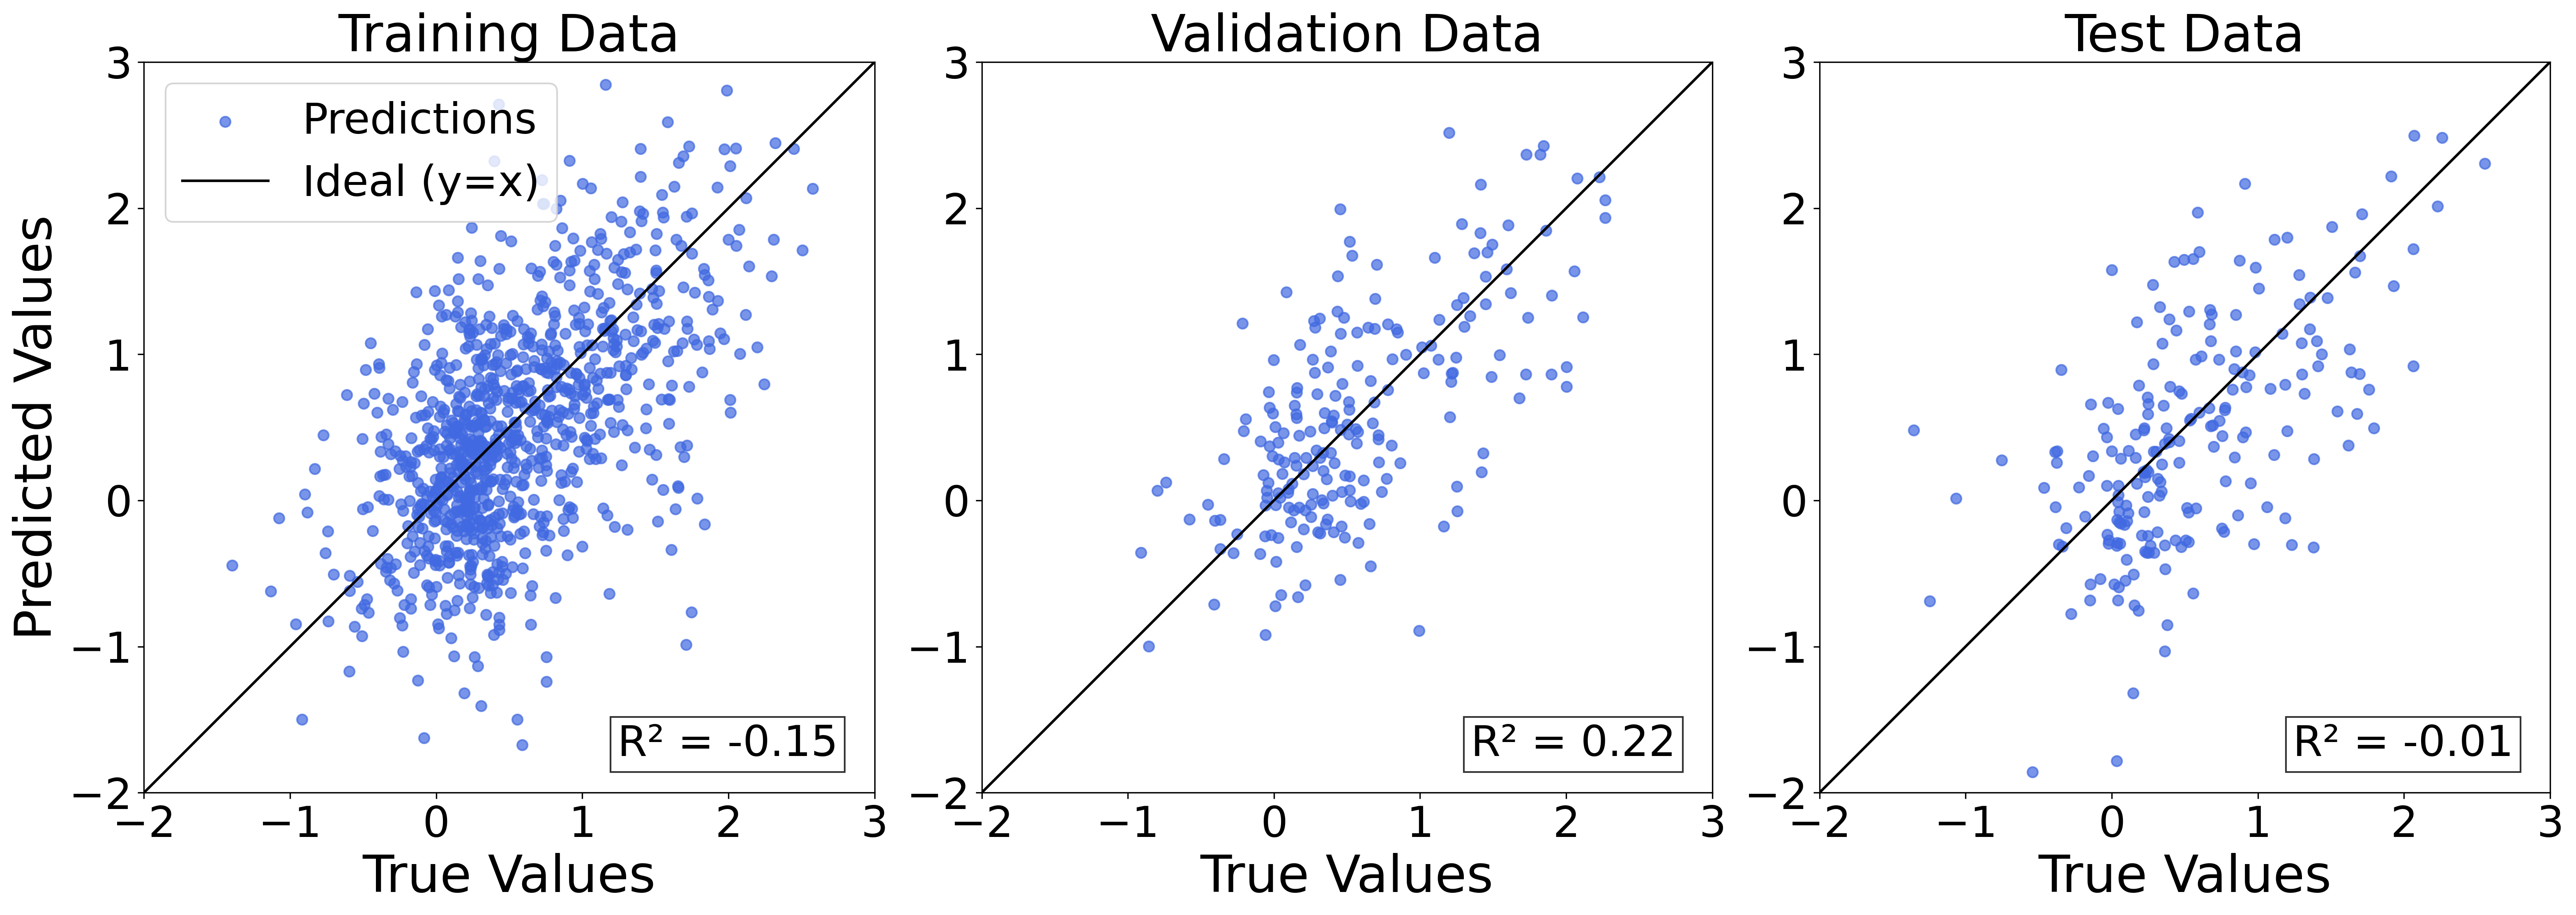

In [ ]:
import pprint
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, mean_squared_error, r2_score

# --- Configuration ---
outlier_threshold = 0.8


# --- Set model to evaluation mode ---
model.eval()

# --- Initialize dictionary for original outlier info ---
original_outlier_info = {} # Changed from list to dict

# --- Initialize Plotting ---
print(f"Plotting results and finding outliers with threshold = {outlier_threshold}...")
fig, axes = plt.subplots(1, 3, figsize=(21, 10), dpi=300)
# fig.suptitle('Predicted vs. True Values - Outlier Visualization', fontsize=16)

# --- Process Train Data (Using non-shuffled loader for index mapping) ---
print("Processing Training data...")
y_true_train = []
y_pred_train = []
# IMPORTANT: Use a non-shuffled loader for the training set to map indices correctly
if 'train_loader_noshuffle' not in locals():
     print("Warning: 'train_loader_noshuffle' not found. Creating one. Ensure train_data exists.")
     train_loader_noshuffle = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)

with torch.no_grad():
    for data in train_loader_noshuffle: # Use the non-shuffled loader here
        data = data.to(device)
        y_true_train.append(data.y)
        y_pred_train.append(model(z = data.z, pos = data.pos, batch = data.batch))

y_true_train = torch.cat(y_true_train, dim=0).cpu().numpy()
y_pred_train = torch.cat(y_pred_train, dim=0).cpu().numpy()

# Calculate R²
r2_train = round(r2_score(y_true_train, y_pred_train), 3)
print(f"R² Score Train set: {r2_train}")

# Identify outliers
error_train = np.abs(y_true_train - y_pred_train)
outlier_mask_train = error_train >= outlier_threshold 
non_outlier_mask_train = ~outlier_mask_train

# Find outlier indices within the split
split_outlier_indices_train = np.where(outlier_mask_train)[0]

# --- Store outlier info in the dictionary ---
num_outliers_train = 0
for split_idx in split_outlier_indices_train:
    original_idx = train_indices[split_idx]
    true_val = y_true_train[split_idx].item() # Use .item() to get scalar value
    pred_val = y_pred_train[split_idx].item() # Use .item() to get scalar value
    original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
    num_outliers_train += 1
print(f"Found and stored {num_outliers_train} outliers in train set.")

# Train Data Plot (Plotting code remains the same)
title_fontsize = 30
axlabel_fontsize = 30
ticklabel_fontsize = 25

axes[0].scatter(y_true_train, y_pred_train,
                color='royalblue', alpha=0.7, label='Predictions')
axes[0].plot([-2, 3], [-2, 3], 'k-', linewidth=1.5, label='Ideal (y=x)')
axes[0].set_xlabel("True Values", fontsize = axlabel_fontsize)
axes[0].set_ylabel("Predicted Values", fontsize = axlabel_fontsize)
axes[0].set_title("Training Data", fontsize = title_fontsize)
axes[0].legend(fontsize = 25, loc='upper left')
#axes[0].grid(True)
axes[0].set_xlim(-2, 3)
axes[0].set_xticks(np.arange(-2, 3.1, 1))
axes[0].set_ylim(-2, 3)
axes[0].set_yticks(np.arange(-2, 3.1, 1))
axes[0].tick_params(axis='both', which='major', labelsize=ticklabel_fontsize) # Increased tick label size
axes[0].set_aspect('equal', adjustable='box')
axes[0].text(0.95, 0.05, f"R² = {r2_train:.2f}", transform=axes[0].transAxes, ha='right', fontsize=25, bbox=dict(facecolor='white', alpha=0.8))

# --- Process Validation Data ---
print("Processing Validation data...")
y_true_val = []
y_pred_val = []
with torch.no_grad():
    for data in val_loader:
        data = data.to(device)
        y_true_val.append(data.y)
        y_pred_val.append(model(z = data.z, pos = data.pos, batch = data.batch))

y_true_val = torch.cat(y_true_val, dim=0).cpu().numpy()
y_pred_val = torch.cat(y_pred_val, dim=0).cpu().numpy()

# Calculate R²
r2_val = round(r2_score(y_true_val, y_pred_val), 3)
print(f"R² Score Val set: {r2_val}")

# Identify outliers
error_val = np.abs(y_true_val - y_pred_val)
outlier_mask_val = error_val >= outlier_threshold # Fixed HTML entity
non_outlier_mask_val = ~outlier_mask_val

# Find outlier indices within the split
split_outlier_indices_val = np.where(outlier_mask_val)[0]

# --- Store outlier info in the dictionary ---
num_outliers_val = 0
for split_idx in split_outlier_indices_val:
    original_idx = val_indices[split_idx]
    true_val = y_true_val[split_idx].item()
    pred_val = y_pred_val[split_idx].item()
    # Check if index already exists (e.g., if a point was somehow in multiple splits - unlikely but safe)
    if original_idx not in original_outlier_info:
         original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
         num_outliers_val += 1
    else:
         print(f"Warning: Index {original_idx} from validation set already found as outlier.")
print(f"Found and stored {num_outliers_val} new outliers in validation set.")


# Validation Data Plot (Plotting code remains the same)
axes[1].scatter(y_true_val, y_pred_val,
                color='royalblue', alpha=0.7, label='Non-Outliers')
axes[1].plot([-2, 3], [-2, 3], 'k-', linewidth=1.5, label='Ideal (y=x)')
axes[1].set_xlabel("True Values", fontsize = axlabel_fontsize)
#axes[1].set_ylabel("Predicted Values")
axes[1].set_title("Validation Data", fontsize = title_fontsize)
#axes[1].legend()
#axes[1].grid(True)
axes[1].set_xlim(-2, 3)
axes[1].set_xticks(np.arange(-2, 3.1, 1))
axes[1].set_ylim(-2, 3)
axes[1].set_yticks(np.arange(-2, 3.1, 1))
axes[1].tick_params(axis='both', which='major', labelsize=ticklabel_fontsize) # Increased tick label size
axes[1].set_aspect('equal', adjustable='box')
axes[1].text(0.95, 0.05, f"R² = {r2_val:.2f}", transform=axes[1].transAxes, ha='right', fontsize=25, bbox=dict(facecolor='white', alpha=0.8))

# --- Process Test Data ---
print("Processing Test data...")
y_true_test = []
y_pred_test = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        y_true_test.append(data.y)
        y_pred_test.append(model(z = data.z, pos = data.pos, batch = data.batch))

y_true_test = torch.cat(y_true_test, dim=0).cpu().numpy()
y_pred_test = torch.cat(y_pred_test, dim=0).cpu().numpy()

# Calculate R²
r2_test = round(r2_score(y_true_test, y_pred_test), 3)
print(f"R² Score Test set: {r2_test}")

# Identify outliers
error_test = np.abs(y_true_test - y_pred_test)
outlier_mask_test = error_test >= outlier_threshold # Fixed HTML entity
non_outlier_mask_test = ~outlier_mask_test

# Find outlier indices within the split
split_outlier_indices_test = np.where(outlier_mask_test)[0]

# --- Store outlier info in the dictionary ---
num_outliers_test = 0
for split_idx in split_outlier_indices_test:
    original_idx = test_indices[split_idx]
    true_val = y_true_test[split_idx].item()
    pred_val = y_pred_test[split_idx].item()
    if original_idx not in original_outlier_info:
         original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
         num_outliers_test += 1
    else:
         print(f"Warning: Index {original_idx} from test set already found as outlier.")
print(f"Found and stored {num_outliers_test} new outliers in test set.")

# Test Data Plot (Plotting code remains the same)
axes[2].scatter(y_true_test, y_pred_test,
                color='royalblue', alpha=0.7, label='Non-Outliers')
axes[2].plot([-2, 3], [-2, 3], 'k-', linewidth=1.5, label='Ideal (y=x)')
axes[2].set_xlabel("True Values", fontsize = axlabel_fontsize)
#axes[2].set_ylabel("Predicted Values")
axes[2].set_title("Test Data", fontsize = title_fontsize)
#axes[2].legend()
#axes[2].grid(True)
axes[2].set_xlim(-2, 3)
axes[2].set_xticks(np.arange(-2, 3.1, 1))
axes[2].set_ylim(-2, 3)
axes[2].set_yticks(np.arange(-2, 3.1, 1))
axes[2].tick_params(axis='both', which='major', labelsize=ticklabel_fontsize) # Increased tick label size
axes[2].set_aspect('equal', adjustable='box')
axes[2].text(0.95, 0.05, f"R² = {r2_test:.2f}", transform=axes[2].transAxes, ha='right', fontsize=25, bbox=dict(facecolor='white', alpha=0.8))

# --- Finalize and Show Results ---
# Sort the dictionary by key (original index) for consistent output
sorted_outlier_info = dict(sorted(original_outlier_info.items()))

print(f"\nTotal number of unique outliers found: {len(sorted_outlier_info)}")
print("Original indices and values of outliers (from graph_data):")
# Pretty print the dictionary (optional, good for large dicts)
pprint.pprint(sorted_outlier_info, indent=2)

plt.savefig('../Figures/SCHNET_trueVspred.png', transparent=True, bbox_inches='tight')